#Install packages

In [ ]:
!pip install firebase-admin
!pip install pydub
!pip install noisereduce

# Firebase - initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import firebase_admin
from firebase_admin import credentials

cred = credentials.Certificate("/content/drive/MyDrive/Colab Notebooks/arthur_private_key.json")
#cred = credentials.Certificate("arthur_private_key_1.json")
firebase_admin.initialize_app(cred)

# Get data from firestore

In [ ]:
from firebase_admin import firestore
import io
import matplotlib.pyplot as plt
import numpy as np
import ast
import librosa
import librosa.display
from array import array
from pydub.playback import play
from pydub.effects import low_pass_filter
from pydub import AudioSegment
import noisereduce as nr
from IPython.display import Audio, display
from scipy import signal
from pydub import scipy_effects

In [ ]:
def filter_audio(audio_segment):
  cleaned_audio = scipy_effects.low_pass_filter(audio_segment, 900, order=15)
  cleaned_audio = scipy_effects.high_pass_filter(cleaned_audio, 100, order=15)
  return cleaned_audio

def denoise_audio_segment(audio_segment):
    samples = np.array(audio_segment.get_array_of_samples())
    reduced_noise = nr.reduce_noise(y=samples, sr=audio_segment.frame_rate,prop_decrease=0.987,stationary=False, chunk_size=1000)

    denoised_audio_segment = AudioSegment(
        reduced_noise.tobytes(),
        frame_rate=audio_segment.frame_rate,
        sample_width=audio_segment.sample_width,
        channels=audio_segment.channels
    )

    #denoised_audio_segment_filtered = filter_audio(denoised_audio_segment)
    # Set parameters for silence detection and removal
    #silence_threshold = -55  # in dBFS (adjust as needed)
    #silence_duration = 1 # in milliseconds (adjust as needed)
    #low_volume_dBFS = 60  # dBFS level for low volume

    #denoised_audio_segment_removed_silence = denoised_audio_segment_filtered
    #silence_chunks = [chunk for chunk in denoised_audio_segment_removed_silence[::silence_duration]]

    #non_silent_audio = AudioSegment.empty()
    # Apply low volume to silence chunks
    #for chunk in silence_chunks:
    #    if chunk.dBFS <= silence_threshold:
    #      # Set volume level for silence chunk
    #      chunk = chunk-low_volume_dBFS  # adjust dBFS to reach low_volume_dBFS
    #    non_silent_audio += chunk
    #non_silent_audio = filter_audio(non_silent_audio)

    return audio_segment, denoised_audio_segment


def plot_and_play_audio_segments(original_audio_segment, denoised_audio_segment):

    original_samples = np.array(original_audio_segment.get_array_of_samples())
    denoised_samples = np.array(denoised_audio_segment.get_array_of_samples())


    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    waveform_ylim = min(np.min(original_samples), np.min(denoised_samples)), max(np.max(original_samples), np.max(denoised_samples))
    axs[0, 0].plot(original_samples)
    axs[0, 0].set_title('Original Audio Waveform')
    axs[0, 0].set_xlabel('Sample')
    axs[0, 0].set_ylabel('Amplitude')
    axs[0, 0].set_ylim(waveform_ylim)


    axs[1, 0].specgram(original_samples, Fs=original_audio_segment.frame_rate)
    axs[1, 0].set_title('Original Audio Spectrogram')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Frequency')


    axs[0, 1].plot(denoised_samples)
    axs[0, 1].set_title('Denoised Audio Waveform')
    axs[0, 1].set_xlabel('Sample')
    axs[0, 1].set_ylabel('Amplitude')
    axs[0, 1].set_ylim(waveform_ylim)

    axs[1, 1].specgram(denoised_samples, Fs=denoised_audio_segment.frame_rate)
    axs[1, 1].set_title('Denoised Audio Spectrogram')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


    print("Playing Original Audio:")
    #display(Audio(data=original_audio_segment.raw_data, rate=original_audio_segment.frame_rate))
    display(original_audio_segment)


    print("Playing Denoised Audio:")
    #display(Audio(data=denoised_audio_segment.raw_data, rate=denoised_audio_segment.frame_rate))
    display(denoised_audio_segment)

In [ ]:
class AudioWithLabel:
  def __init__(self, label, audio, date):
    self.label = label
    self.audio = audio
    self.date = date

def getAudio(user, firstIndex=None, lastIndex=None):
    audio_ref = user.collection("audio")
    audio_data = audio_ref.stream()
    audio_list = []
    for index, audio_record in enumerate(audio_data):
      if firstIndex is not None and index < firstIndex:
        continue
      if lastIndex is not None and index > lastIndex:
        break
      #print(f"    audio ID: {audio_record.id}, data: {audio_record.to_dict()}")
      label = audio_record.to_dict()['label']
      date = audio_record.to_dict()['date']
      audio_bytes_list = audio_record.to_dict()['audioData']
      platform = audio_record.to_dict()['platform']
      #print(len(audio_bytes_list))
      audio_segment = getAudioSegment(audio_bytes_list, platform)

      new_audio = AudioWithLabel(label, audio_segment, date)
      audio_list.append(new_audio)
      print(f"Audio record index: {index}")


    return audio_list

def adjustAudioSegment(audio_segment):
    new_time = 1.2
    new_time_length = int(new_time * audio_segment.frame_rate)
    current_last_index = len(audio_segment.get_array_of_samples()) - 1;

    highest_amplitude_index = audio_segment.get_array_of_samples().index(max(audio_segment.get_array_of_samples()))

    if(highest_amplitude_index < new_time_length/2):
      adjusted_audio_bytes = audio_segment.get_array_of_samples()[0:new_time_length]
    else:
      if(highest_amplitude_index > current_last_index - new_time_length/2):
        adjusted_audio_bytes = audio_segment.get_array_of_samples()[-new_time_length:]
      else:
        cut_front = int(highest_amplitude_index - new_time_length //2)
        cut_back = int(cut_front + new_time_length )
        adjusted_audio_bytes = audio_segment.get_array_of_samples()[cut_front:cut_back]

    return adjusted_audio_bytes

def clean_audio(audio_segment):
  #cleaned_audio = low_pass_filter(audio_segment, 800)
  original, denoised = denoise_audio_segment(audio_segment)
  #plot_and_play_audio_segments(original, denoised,denoised_filter, denoised_silence)
  return denoised

def getAudioSegment(audio_bytes_list, platform):
    audio_bytes = bytes(audio_bytes_list)

    #if(platform == 'ios'):
    #  audio_segment = AudioSegment.from_file(io.BytesIO(audio_bytes), format="aac")
    #else:
    audio_segment = AudioSegment.from_file(io.BytesIO(audio_bytes), format="mp4")

    adjusted_audio_bytes = adjustAudioSegment(audio_segment)

    new_audio_segment = AudioSegment(adjusted_audio_bytes.tobytes(), frame_rate=audio_segment.frame_rate, sample_width=audio_segment.sample_width, channels=1)

    return clean_audio(new_audio_segment)

def showWaveform(audio_segment):
  plt.figure(figsize=(6, 3))
  plt.title("Waveform")
  plt.xlabel("Sample int")
  plt.ylabel("Amplitude")
  plt.grid()
  plt.plot(audio_segment.get_array_of_samples())
  plt.show()

def showTwoWaveforms(audio_segment, audio_segment2):

  # Create subplots with 1 row and 2 columns
  plt.figure(figsize=(15, 2))

  # Plot the first chart on the left
  plt.subplot(1, 2, 1)
  plt.title("Waveform")
  plt.xlabel("Sample int")
  plt.ylabel("Amplitude")
  plt.grid()
  plt.plot(audio_segment.get_array_of_samples())

  # Plot the second chart on the right
  plt.subplot(1, 2, 2)
  plt.title("Waveform")
  plt.xlabel("Sample int")
  plt.ylabel("Amplitude")
  plt.grid()
  plt.plot(audio_segment2.get_array_of_samples())
  plt.show()


def getLabels(audio):
    word_list = []
    for recording in audio:
      label = recording.label
      if label not in word_list:
        word_list.append(label)

    return word_list


def getFullLabels(audio):
    word_list = []
    for recording in audio:
      label = recording.label
      word_list.append(label)

    return word_list

def showChartsForAll(audio):
  words = getLabels(audio)
  for word in words:
    founded_records = [audio_record for audio_record in audio if hasattr(audio_record, 'label') and audio_record.label == word]
    if(len(founded_records)>2):
      print(word)
      audioFirst = founded_records[len(founded_records) - 1].audio
      audioSecond = founded_records[len(founded_records) - 2].audio
      showTwoWaveforms(audioFirst, audioSecond)

def getSpectogram(audio_record):
  audioSegment = getAudioSegment(audio_record)
  return audioSegment.get_array_of_samples()

In [ ]:
def getFullAudioSegment(audio_bytes_list):
    audio_bytes = bytes(audio_bytes_list)
    audio_segment = AudioSegment.from_file(io.BytesIO(audio_bytes), format="mp4")
    return audio_segment

def getNoise(user):
    audio_ref = user.collection("noise")
    audio_data = audio_ref.stream()
    audio_segments = []
    for index, audio_record in enumerate(audio_data):

      label = audio_record.to_dict()['label']
      date = audio_record.to_dict()['date']
      audio_bytes_list = audio_record.to_dict()['audioData']
      audio_segment = getFullAudioSegment(audio_bytes_list)
      audio_segments.append(audio_segment)

    return audio_segments

def showNoise(user) :
      noise = getNoise(user)
      for n in noise:
        showWaveform(n)

In [ ]:
db = firestore.client()
users_ref = db.collection("users")
users= users_ref.stream()

In [ ]:
piotr = users_ref.document("txt")
piotrAudioFirst = getAudio(piotr, None, 199)


Audio record index: 0
Audio record index: 1
Audio record index: 2
Audio record index: 3
Audio record index: 4
Audio record index: 5
Audio record index: 6
Audio record index: 7
Audio record index: 8
Audio record index: 9
Audio record index: 10
Audio record index: 11
Audio record index: 12
Audio record index: 13
Audio record index: 14
Audio record index: 15
Audio record index: 16
Audio record index: 17
Audio record index: 18
Audio record index: 19
Audio record index: 20
Audio record index: 21
Audio record index: 22
Audio record index: 23
Audio record index: 24
Audio record index: 25
Audio record index: 26
Audio record index: 27
Audio record index: 28
Audio record index: 29
Audio record index: 30
Audio record index: 31
Audio record index: 32
Audio record index: 33
Audio record index: 34
Audio record index: 35
Audio record index: 36
Audio record index: 37
Audio record index: 38
Audio record index: 39
Audio record index: 40
Audio record index: 41
Audio record index: 42
Audio record index: 4

In [ ]:
piotrAudioSecond = getAudio(piotr, 200, None)

Audio record index: 200
Audio record index: 201
Audio record index: 202
Audio record index: 203
Audio record index: 204
Audio record index: 205
Audio record index: 206
Audio record index: 207
Audio record index: 208
Audio record index: 209
Audio record index: 210
Audio record index: 211
Audio record index: 212
Audio record index: 213
Audio record index: 214
Audio record index: 215
Audio record index: 216
Audio record index: 217
Audio record index: 218
Audio record index: 219
Audio record index: 220
Audio record index: 221
Audio record index: 222
Audio record index: 223
Audio record index: 224
Audio record index: 225
Audio record index: 226
Audio record index: 227
Audio record index: 228
Audio record index: 229
Audio record index: 230
Audio record index: 231
Audio record index: 232
Audio record index: 233
Audio record index: 234
Audio record index: 235
Audio record index: 236
Audio record index: 237
Audio record index: 238
Audio record index: 239
Audio record index: 240
Audio record ind

In [ ]:
#piotrAudioThird = getAudio(piotr, None, None)

In [ ]:
user = piotr
audio = piotrAudioFirst+piotrAudioSecond

#Denoising audio - only for test

In [ ]:
# Odszumianie test
print(type(audio))
print(audio[1])

def filter_audio(audio_segment):
  cleaned_audio = scipy_effects.low_pass_filter(audio_segment, 900, order=15)
  cleaned_audio = scipy_effects.high_pass_filter(cleaned_audio, 100, order=15)
  return cleaned_audio

def get_and_denoise_audio_segment(audio_segment):
    samples = np.array(audio_segment.get_array_of_samples())
    reduced_noise = nr.reduce_noise(y=samples, sr=audio_segment.frame_rate,prop_decrease=0.987,stationary=False, chunk_size=1000)

    denoised_audio_segment = AudioSegment(
        reduced_noise.tobytes(),
        frame_rate=audio_segment.frame_rate,
        sample_width=audio_segment.sample_width,
        channels=audio_segment.channels
    )

    denoised_audio_segment_filtered = filter_audio(denoised_audio_segment)
    # Set parameters for silence detection and removal
    silence_threshold = -55  # in dBFS (adjust as needed)
    silence_duration = 1 # in milliseconds (adjust as needed)
    low_volume_dBFS = 60  # dBFS level for low volume

    denoised_audio_segment_removed_silence = denoised_audio_segment_filtered
    silence_chunks = [chunk for chunk in denoised_audio_segment_removed_silence[::silence_duration]]

    non_silent_audio = AudioSegment.empty()
    # Apply low volume to silence chunks
    for chunk in silence_chunks:
        if chunk.dBFS <= silence_threshold:
          # Set volume level for silence chunk
          chunk = chunk-low_volume_dBFS  # adjust dBFS to reach low_volume_dBFS
        non_silent_audio += chunk
    non_silent_audio = filter_audio(non_silent_audio)

    return audio_segment, denoised_audio_segment, denoised_audio_segment_filtered, non_silent_audio


def plot_and_play_audio_segments(original_audio_segment, denoised_audio_segment, denoised_audio_segment_filtered, denoised_audio_segment_removed_silence):

    original_samples = np.array(original_audio_segment.get_array_of_samples())
    denoised_samples = np.array(denoised_audio_segment.get_array_of_samples())
    denoised_samples_filtered = np.array(denoised_audio_segment_filtered.get_array_of_samples())
    denoised_samples_removed_silence = np.array(denoised_audio_segment_removed_silence.get_array_of_samples())
    fig, axs = plt.subplots(4, 2, figsize=(12, 8))

    waveform_ylim = min(np.min(original_samples), np.min(denoised_samples)), max(np.max(original_samples), np.max(denoised_samples))
    axs[0, 0].plot(original_samples)
    axs[0, 0].set_title('Original Audio Waveform')
    axs[0, 0].set_xlabel('Sample')
    axs[0, 0].set_ylabel('Amplitude')
    axs[0, 0].set_ylim(waveform_ylim)


    axs[0, 1].specgram(original_samples, Fs=original_audio_segment.frame_rate)
    axs[0, 1].set_title('Original Audio Spectrogram')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Frequency')

    waveform_ylim = min(np.min(original_samples), np.min(denoised_samples)), max(np.max(original_samples), np.max(denoised_samples))
    axs[1, 0].plot(denoised_samples)
    axs[1, 0].set_title('Denoised Audio Waveform')
    axs[1, 0].set_xlabel('Sample')
    axs[1, 0].set_ylabel('Amplitude')
    axs[1, 0].set_ylim(waveform_ylim)


    axs[1, 1].specgram(denoised_samples, Fs=original_audio_segment.frame_rate)
    axs[1, 1].set_title('Denoised Audio Spectrogram')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Frequency')

    waveform_ylim = min(np.min(original_samples), np.min(denoised_samples)), max(np.max(original_samples), np.max(denoised_samples))
    axs[2, 0].plot(denoised_samples_filtered)
    axs[2, 0].set_title('Filtered Denoised Audio Waveform')
    axs[2, 0].set_xlabel('Sample')
    axs[2, 0].set_ylabel('Amplitude')
    axs[2, 0].set_ylim(waveform_ylim)


    axs[2, 1].specgram(denoised_samples_filtered, Fs=original_audio_segment.frame_rate)
    axs[2, 1].set_title('Filtered Denoised Audio Spectrogram')
    axs[2, 1].set_xlabel('Time')
    axs[2, 1].set_ylabel('Frequency')

    waveform_ylim = min(np.min(original_samples), np.min(denoised_samples)), max(np.max(original_samples), np.max(denoised_samples))
    axs[3, 0].plot(denoised_samples_removed_silence)
    axs[3, 0].set_title('Filtered Denoised Removed Low Amplitudes Audio Waveform')
    axs[3, 0].set_xlabel('Sample')
    axs[3, 0].set_ylabel('Amplitude')
    axs[3, 0].set_ylim(waveform_ylim)


    axs[3, 1].specgram(denoised_samples_removed_silence, Fs=original_audio_segment.frame_rate)
    axs[3, 1].set_title('Filtered Denoised Removed Low Amplitudes Audio Spectrogram')
    axs[3, 1].set_xlabel('Time')
    axs[3, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


    print("Playing Original Audio:")
    #display(Audio(data=original_audio_segment.raw_data, rate=original_audio_segment.frame_rate))
    display(original_audio_segment)

    print("Playing Denoised Audio:")
    #display(Audio(data=denoised_audio_segment.raw_data, rate=denoised_audio_segment.frame_rate))
    display(denoised_audio_segment)

    print("Playing moreDenoised Audio:")
    #display(Audio(data=denoised_audio_segment.raw_data, rate=denoised_audio_segment.frame_rate))
    display(denoised_audio_segment_filtered)

    print("Playing moreDenoised Audio:")
    #display(Audio(data=denoised_audio_segment.raw_data, rate=denoised_audio_segment.frame_rate))
    display(denoised_audio_segment_removed_silence)

<class 'list'>


<class 'pydub.audio_segment.AudioSegment'>
Kocham Was


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


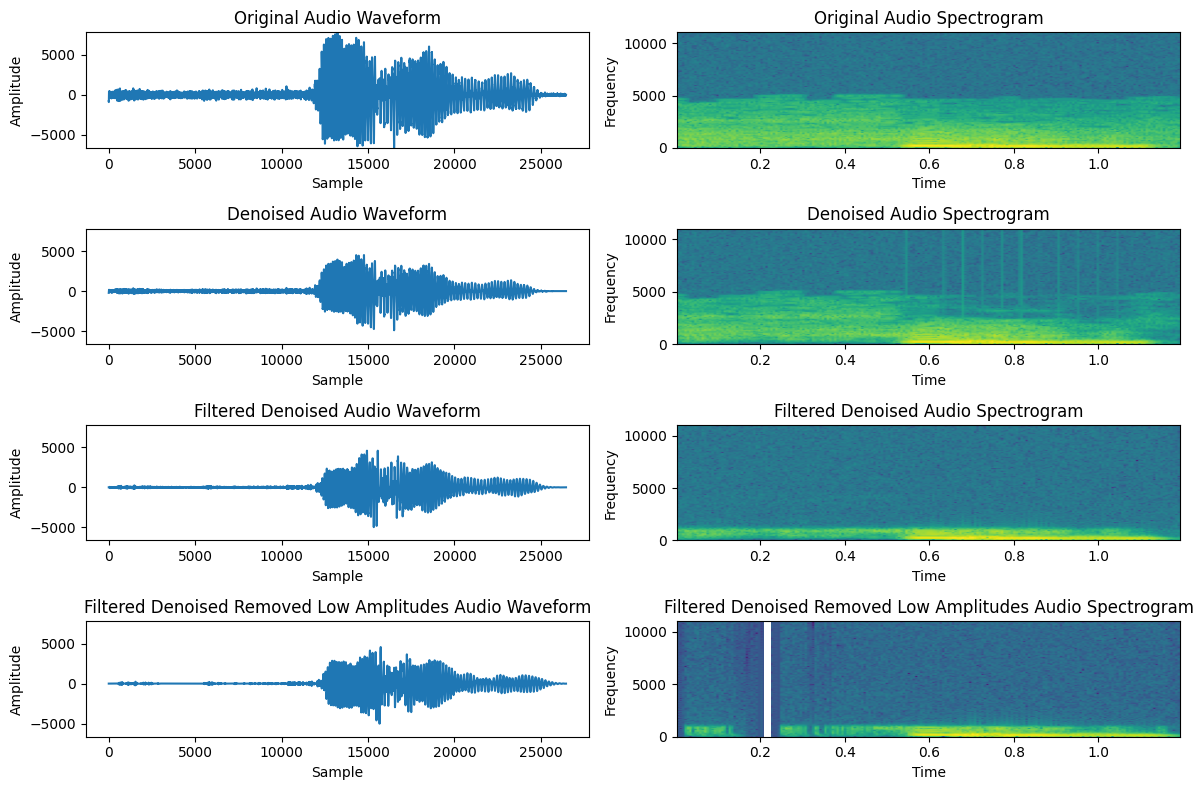

Playing Original Audio:


Playing Denoised Audio:


Playing moreDenoised Audio:


Playing moreDenoised Audio:


In [ ]:
sample1=audio[111]
original, denoised, denoised_filter, denoised_silence = denoise_audio_segment(sample1.audio)
print(type(denoised))
print(sample1.label)

plot_and_play_audio_segments(original, denoised,denoised_filter, denoised_silence)

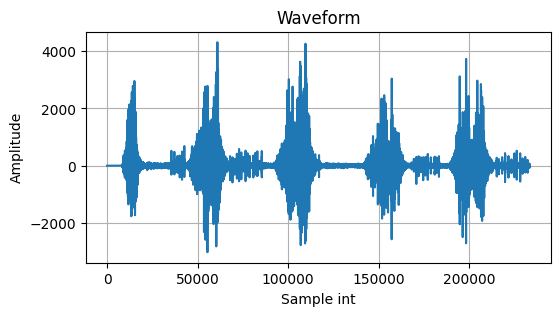

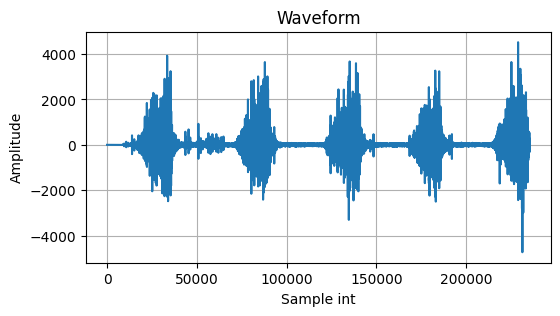

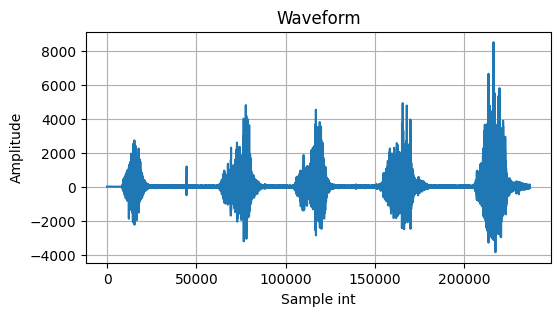

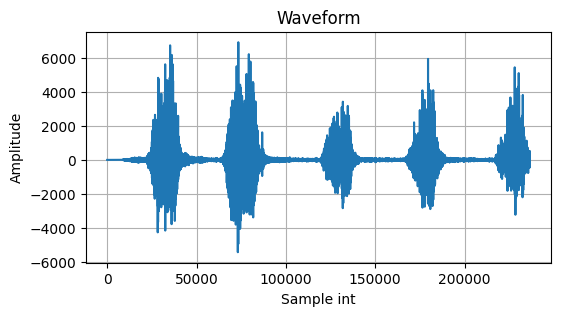

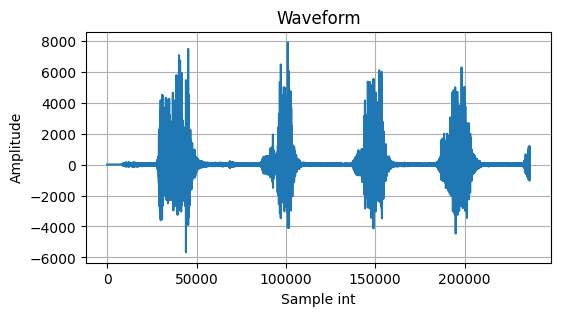

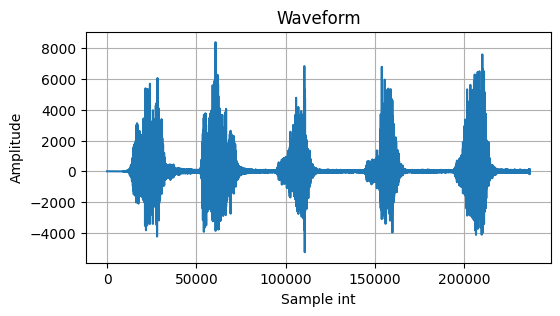

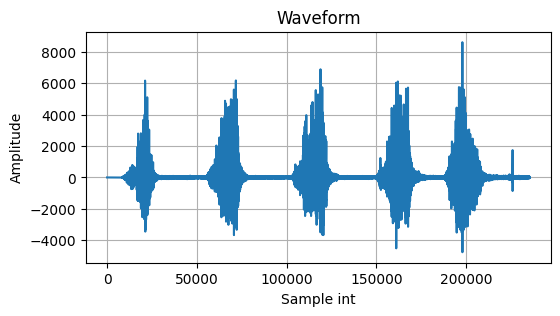

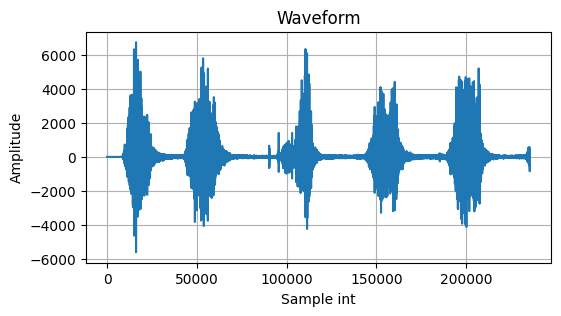

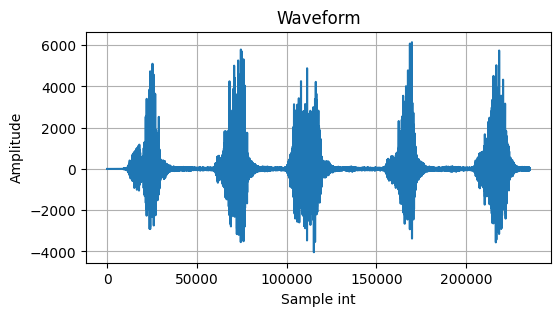

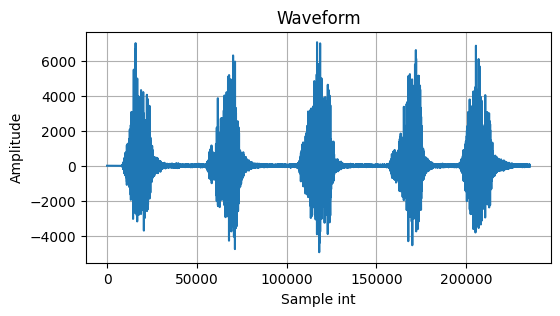

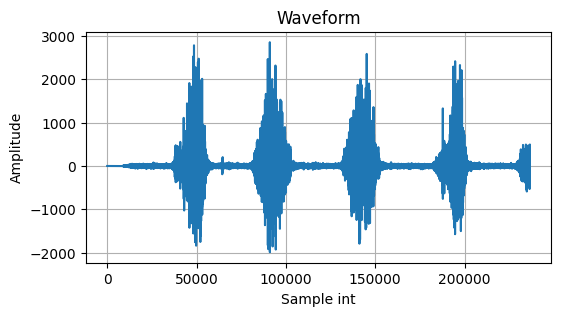

In [ ]:
showNoise(user)

# Show data on charts

Cześć


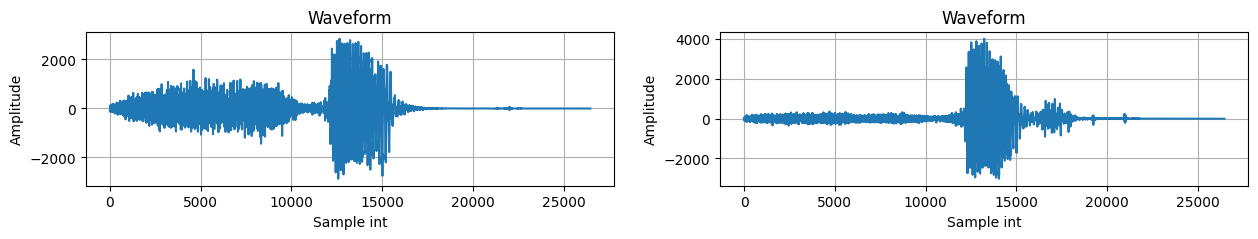

Dziękuję


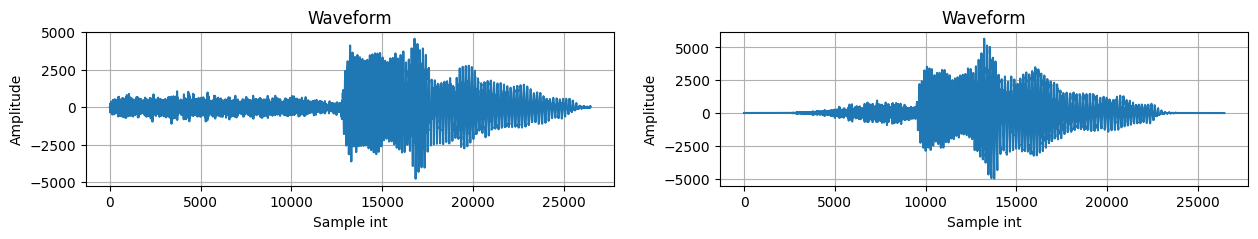

Kocham Was


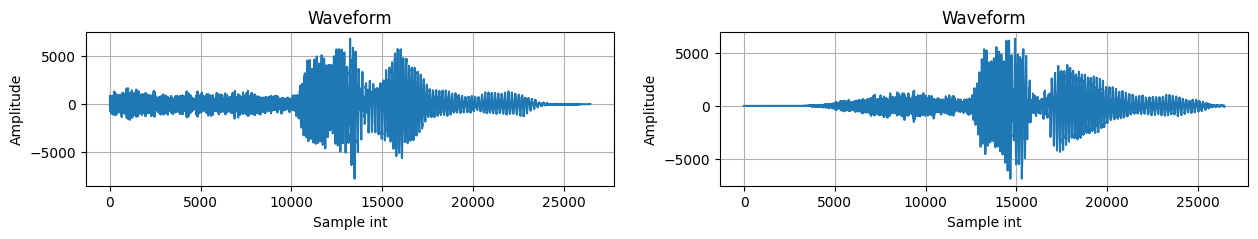

Mama


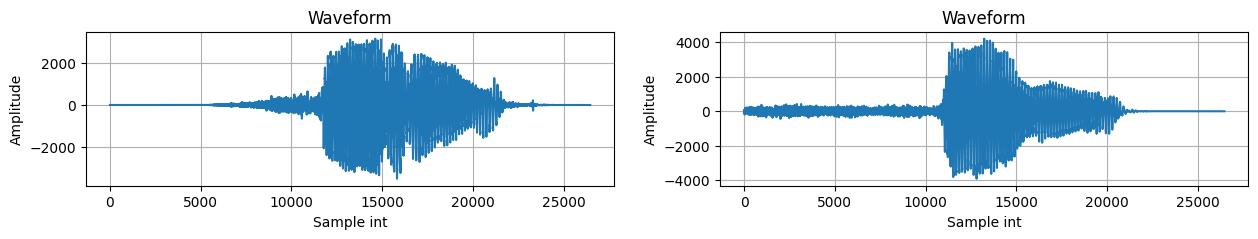

Tata


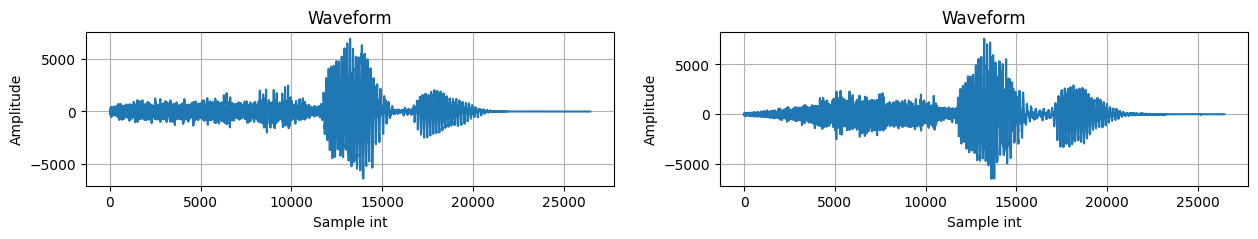

Wesołych Świąt


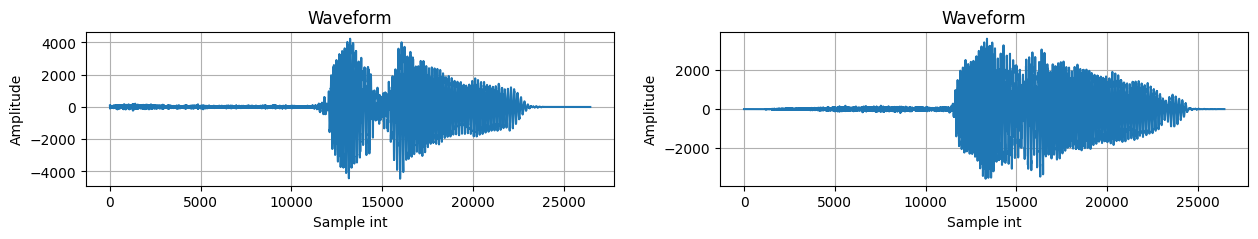

Łezka


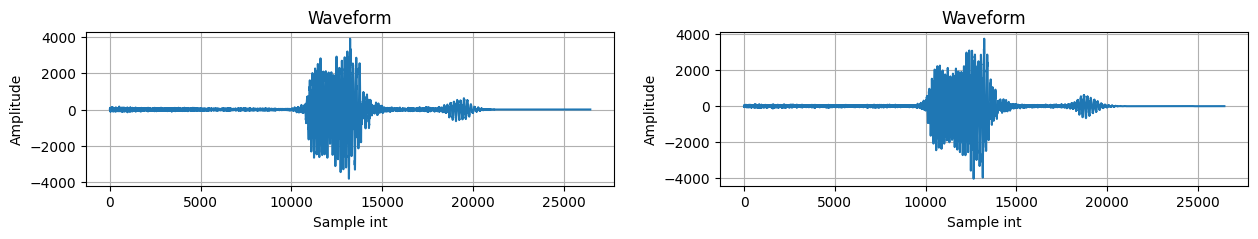

Ślina


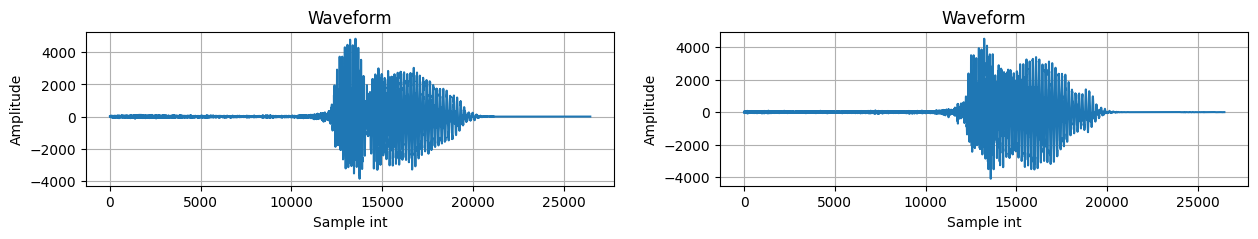

In [ ]:
showChartsForAll(audio)

# Prepare data


## Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def label_encoding(data):
    label_encoder = LabelEncoder()
    integer_encoded_labels = label_encoder.fit_transform(data)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded_labels = integer_encoded_labels.reshape(len(integer_encoded_labels), 1)
    onehot_encoded_labels = onehot_encoder.fit_transform(integer_encoded_labels)

    return integer_encoded_labels

labels = getFullLabels(audio)
encoded_labels = label_encoding(labels)

print("Etykiety (oryginalne):", labels)
#print("Etykiety (zakodowane):", encoded_labels)

Etykiety (oryginalne): ['Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Cześć', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dziękuję', 'Dzięku

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
short_labels = labels = getLabels(audio)
print(short_labels)

['Cześć', 'Dziękuję', 'Kocham Was', 'Mama', 'Tata', 'Wesołych Świąt', 'Łezka', 'Ślina']


## Feature Extraction

###Custom Feature

In [ ]:
#check how many values > 5000
#max_range = 8000
#top_range = 6500
#mid_range = 5000
#bottom_range = 3500
#min_range = 2500
max_range = 6000
top_range = 5500
mid_range = 4000
bottom_range = 3500
min_range = 3000

def calculate_custom_feature_elements(value, range, total_count, consecutive_count, consecutive_count_max_length, series_count):
    if value > range:
      total_count += 1
      consecutive_count += 1
    else:
      if consecutive_count > 0:
        series_count += 1
      if(consecutive_count > consecutive_count_max_length):
         consecutive_count_max_length = consecutive_count
      consecutive_count = 0
    return total_count, consecutive_count, consecutive_count_max_length, series_count


def count_values_above_ranges(audio_segment):
    segment_array = audio_segment.get_array_of_samples()

    total_count_top = 0
    consecutive_count_top = 0
    consecutive_count_max_length_top = 0
    series_count_top = 0

    total_count_max = 0
    consecutive_count_max = 0
    consecutive_count_max_length_max = 0
    series_count_max = 0

    total_count_mid = 0
    consecutive_count_mid = 0
    consecutive_count_max_length_mid = 0
    series_count_mid = 0

    total_count_bottom = 0
    consecutive_count_bottom = 0
    consecutive_count_max_length_bottom = 0
    series_count_bottom = 0

    total_count_min = 0
    consecutive_count_min = 0
    consecutive_count_max_length_min = 0
    series_count_min = 0

    for value in segment_array:
      total_count_top, consecutive_count_top, consecutive_count_max_length_top, series_count_top = calculate_custom_feature_elements(value, top_range, total_count_top, consecutive_count_top, consecutive_count_max_length_top, series_count_top)
      total_count_max, consecutive_count_max, consecutive_count_max_length_max, series_count_max = calculate_custom_feature_elements(value, max_range, total_count_max, consecutive_count_max, consecutive_count_max_length_max, series_count_max)
      total_count_mid, consecutive_count_mid, consecutive_count_max_length_mid, series_count_mid = calculate_custom_feature_elements(value, mid_range, total_count_mid, consecutive_count_mid, consecutive_count_max_length_mid, series_count_mid)
      total_count_bottom, consecutive_count_bottom, consecutive_count_max_length_bottom, series_count_bottom = calculate_custom_feature_elements(value, bottom_range, total_count_bottom, consecutive_count_bottom, consecutive_count_max_length_bottom, series_count_bottom)
      total_count_min, consecutive_count_min, consecutive_count_max_length_min, series_count_min = calculate_custom_feature_elements(value, min_range, total_count_min, consecutive_count_min, consecutive_count_max_length_min, series_count_min)

    range_list_top = [total_count_top, consecutive_count_max_length_top, series_count_top]
    range_list_mid = [total_count_mid, consecutive_count_max_length_mid, series_count_mid]
    range_list_bottom = [total_count_bottom, consecutive_count_max_length_bottom, series_count_bottom]
    range_list_min = [total_count_min, consecutive_count_max_length_min, series_count_min]
    range_list_max = [total_count_max, consecutive_count_max_length_max, series_count_max]

    matrice = [range_list_max, range_list_top, range_list_mid, range_list_bottom, range_list_min]
    print(np.array(matrice).shape)
    return matrice

def printBigValuesCount(audioBytesList, audioBytesList2):
  countAboveTopRanges = count_values_above_ranges(audioBytesList)
  countAboveTopRanges2 = count_values_above_ranges(audioBytesList2)
  print(countAboveTopRanges)
  print(countAboveTopRanges2)

def printForAll(audio):
  words = getLabels(audio)
  for word in words:
    founded_records = [audio_record for audio_record in audio if hasattr(audio_record, 'label') and audio_record.label == word]
    if(len(founded_records)>2):
      print(word)
      printBigValuesCount(founded_records[len(founded_records) - 1].audio, founded_records[len(founded_records) - 2].audio)

printForAll(audio)


Cześć
(5, 3)
(5, 3)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[0, 0, 0], [0, 0, 0], [1, 1, 1], [35, 9, 6], [89, 14, 10]]
Dziękuję
(5, 3)
(5, 3)
[[0, 0, 0], [0, 0, 0], [17, 10, 3], [93, 16, 14], [290, 35, 30]]
[[0, 0, 0], [3, 3, 1], [78, 19, 8], [147, 28, 10], [338, 48, 27]]
Kocham Was
(5, 3)
(5, 3)
[[6, 6, 1], [60, 19, 8], [370, 47, 28], [603, 50, 42], [871, 54, 42]]
[[15, 7, 3], [28, 11, 4], [261, 33, 20], [388, 46, 25], [637, 51, 39]]
Mama
(5, 3)
(5, 3)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [32, 7, 7]]
[[0, 0, 0], [0, 0, 0], [10, 4, 3], [101, 11, 15], [375, 29, 24]]
Tata
(5, 3)
(5, 3)
[[21, 8, 5], [42, 10, 7], [230, 43, 20], [324, 52, 21], [458, 56, 32]]
[[23, 8, 3], [50, 11, 8], [193, 31, 15], [302, 37, 23], [437, 41, 25]]
Wesołych Świąt
(5, 3)
(5, 3)
[[0, 0, 0], [0, 0, 0], [10, 7, 3], [96, 20, 10], [288, 41, 23]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [4, 4, 1], [82, 21, 11]]
Łezka
(5, 3)
(5, 3)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [6, 6, 1], [21, 10, 3]]
[[0, 0, 0], 

###Audio envelope


Cześć
(52,)
(52,)


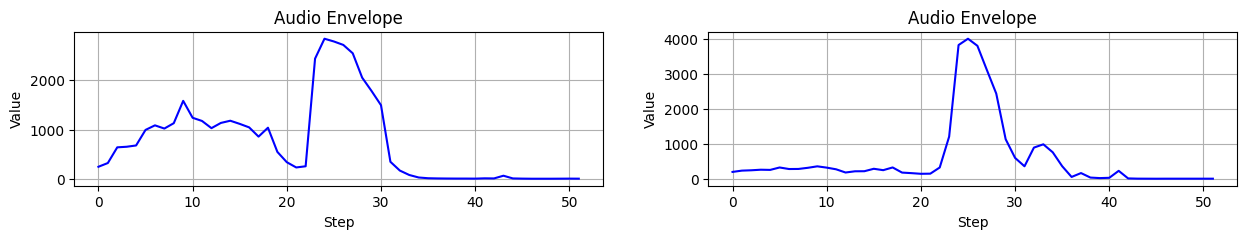

Dziękuję
(52,)
(52,)


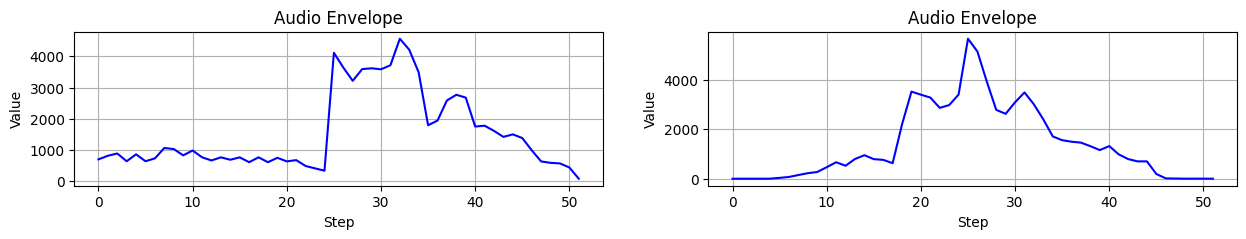

Kocham Was
(52,)
(52,)


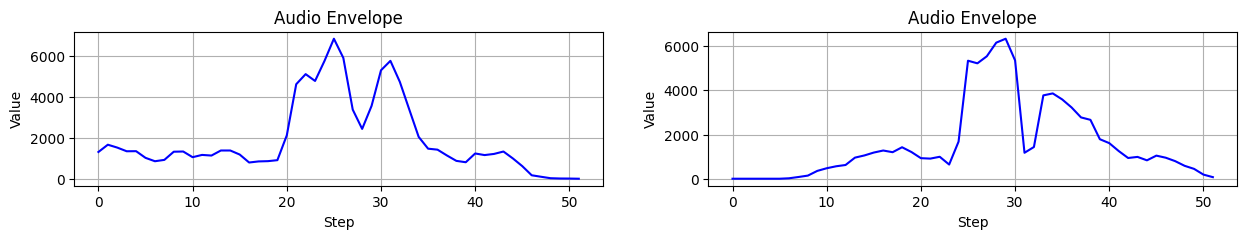

Mama
(52,)
(52,)


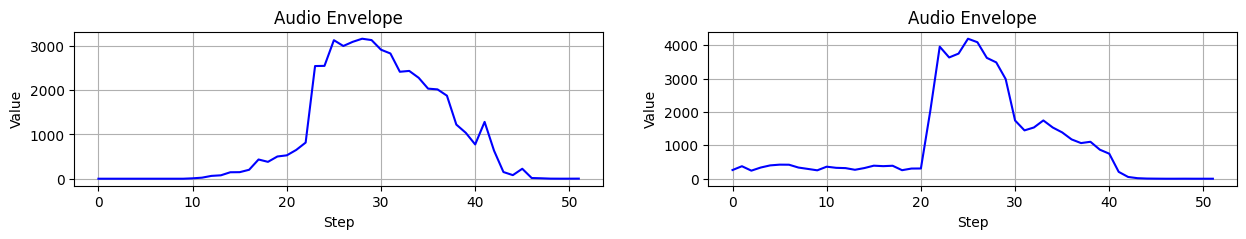

Tata
(52,)
(52,)


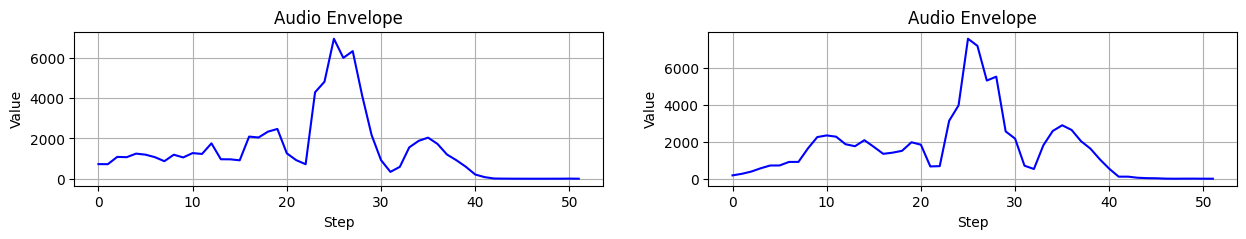

Wesołych Świąt
(52,)
(52,)


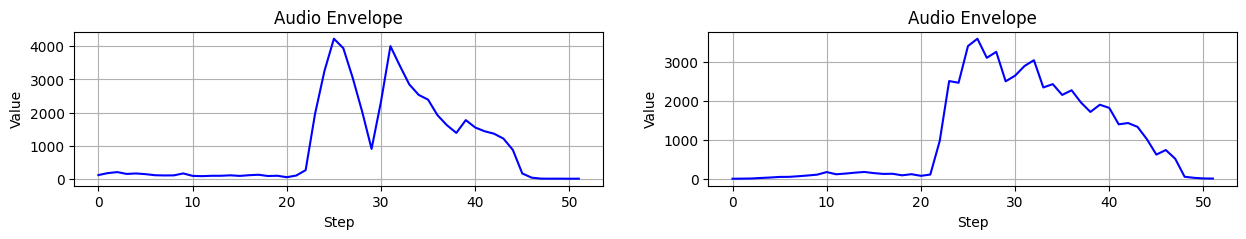

Łezka
(52,)
(52,)


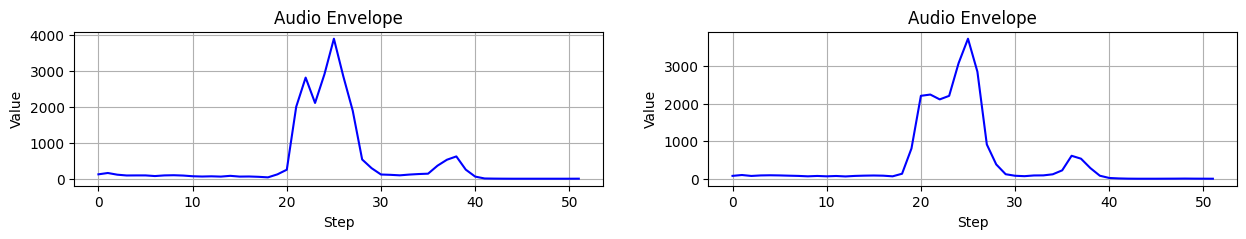

Ślina
(52,)
(52,)


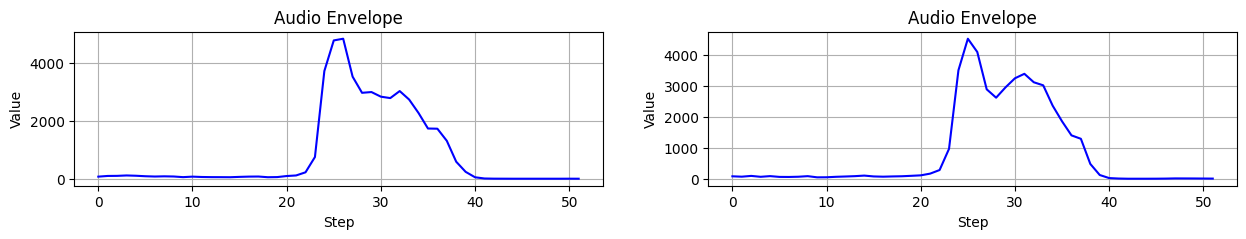

In [ ]:
step = 510

def get_audio_envelope(audio_segment):
    audio_array = audio_segment.get_array_of_samples()
    envelope_array = []

    for start in range(0, len(audio_array), step):
      end = min(start + step, len(audio_array))
      max_value = max(audio_array[start:end])
      envelope_array.append(max_value)


    return envelope_array

def draw_audio_envelope(audio_bytes_list):
    envelope_array = get_audio_envelope(audio_bytes_list)
    print(np.array(envelope_array).shape)
    #plt.figure(figsize=(5, 2))
    plt.plot(np.arange(len(envelope_array)), envelope_array, color='blue')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Audio Envelope')
    plt.grid(True)
    #plt.show()

def draw_two_audio_envelope(audio_bytes_list, audio_bytes_list2):
    # Create subplots with 1 row and 2 columns
    plt.figure(figsize=(15, 2))

    # Plot the first chart on the left
    plt.subplot(1, 2, 1)
    draw_audio_envelope(audio_bytes_list)

    # Plot the second chart on the right
    plt.subplot(1, 2, 2)
    draw_audio_envelope(audio_bytes_list2)

    plt.show()

def drawEnvelopeForAll(audio):
  words = getLabels(audio)
  for word in words:
    founded_records = [audio_record for audio_record in audio if hasattr(audio_record, 'label') and audio_record.label == word]
    if(len(founded_records)>2):
      print(word)
      draw_two_audio_envelope(founded_records[len(founded_records) - 1].audio, founded_records[len(founded_records) - 2].audio)


drawEnvelopeForAll(audio)
#print('TEST:')
#drawEnvelopeForAll(test)

###MFCCs


Cześć


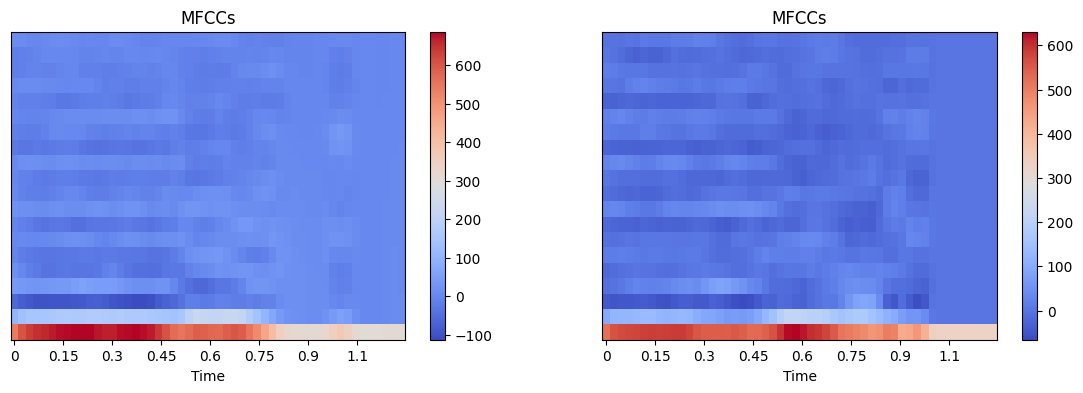

Dziękuję


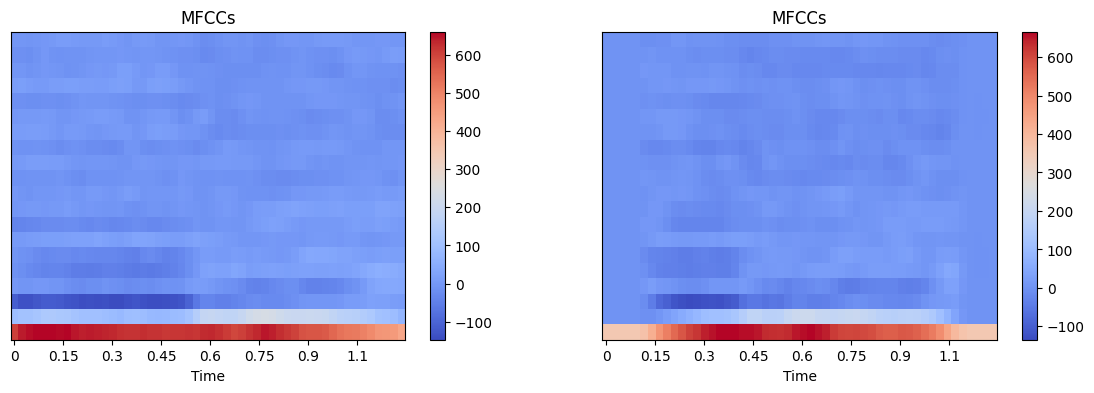

Kocham Was


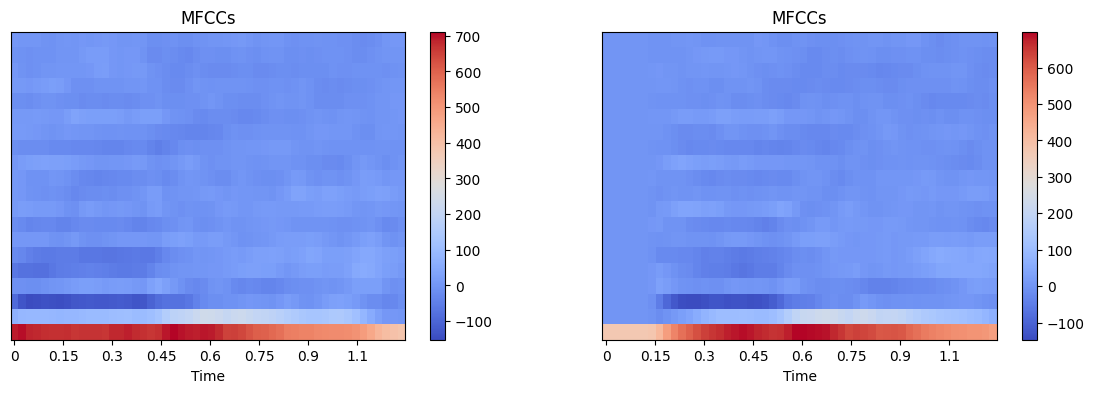

Mama


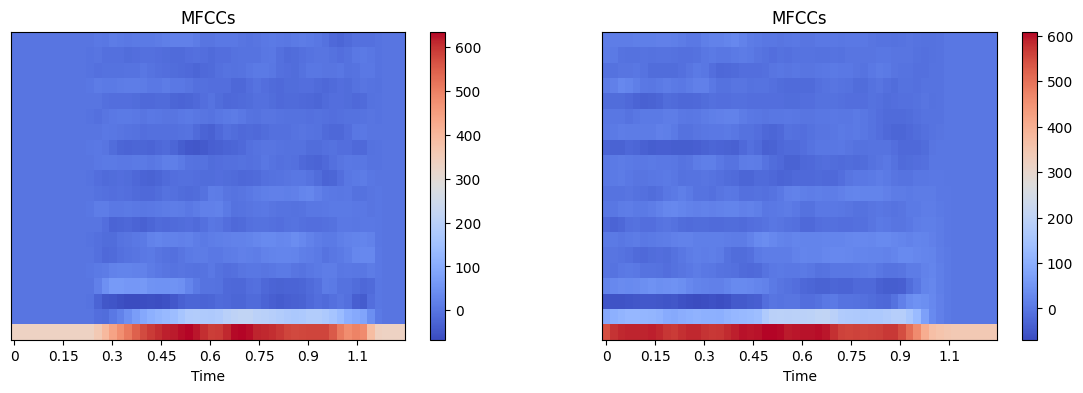

Tata


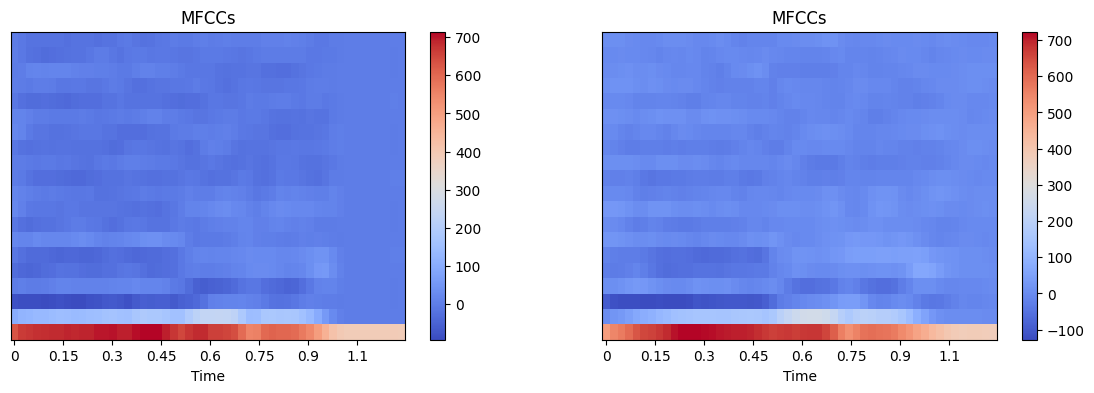

Wesołych Świąt


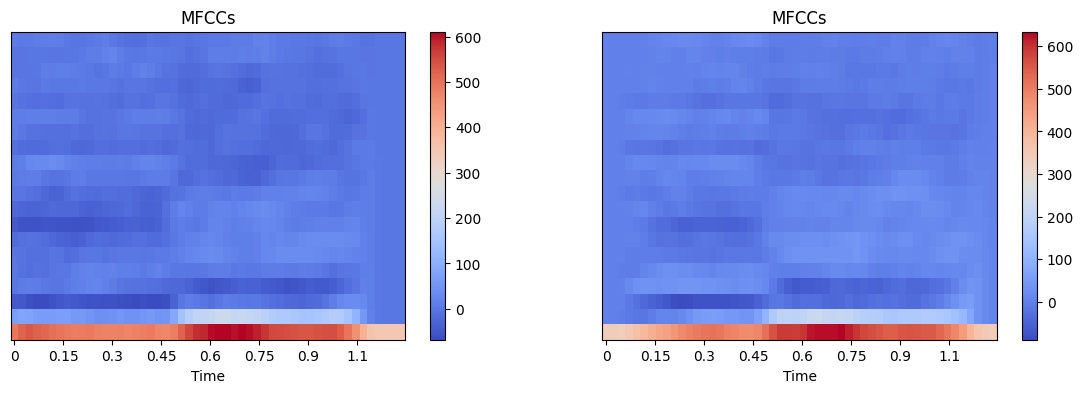

Łezka


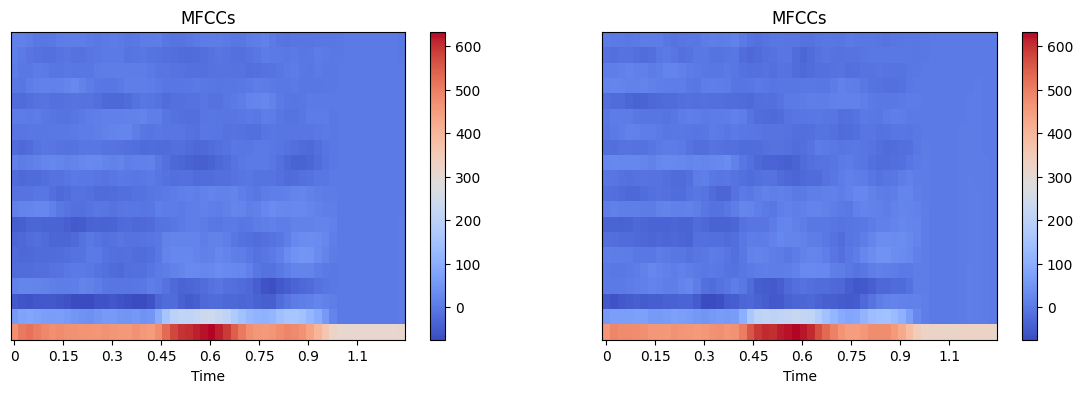

Ślina


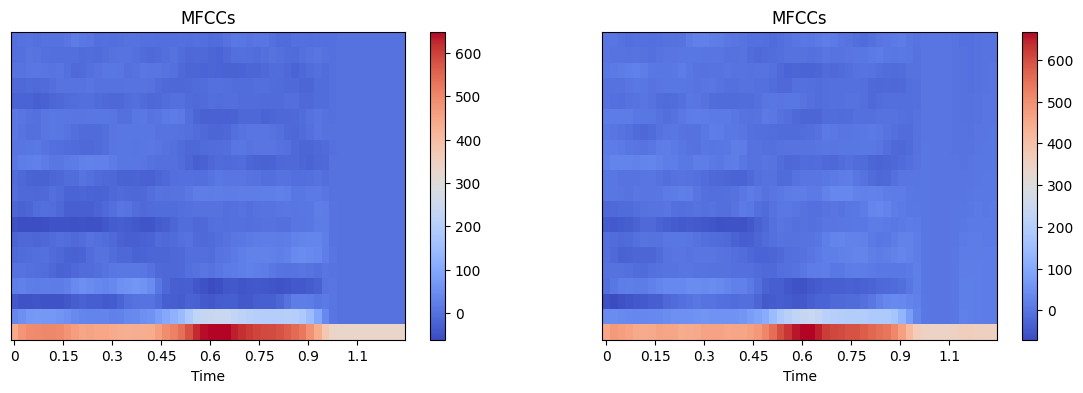

In [ ]:

def getMFCCs(audio_segment):
  audio_np_array = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)
  n_fft1=2048
  hop_length1=2048
  #hop_length1=1024
  win_length1=2048
  n_mfcc1=12
  #mfccs = librosa.feature.mfcc(y=audio_np_array, n_fft=n_fft1,hop_length=hop_length1,win_length=win_length1, n_mfcc=n_mfcc1, sr=22050)
  mfccs=librosa.feature.mfcc(y=audio_np_array, sr=22050)
  #print(mfccs.shape)
  return mfccs

def showMFCCs(audio_segment, audio_segment2):
  mfccs = getMFCCs(audio_segment)
  mfccs2 = getMFCCs(audio_segment2)

  # Create subplots with 1 row and 2 columns
  plt.figure(figsize=(14, 4))

  # Plot the first chart on the left
  plt.subplot(1, 2, 1)
  plt.title("MFCCs")
  librosa.display.specshow(mfccs, x_axis='time')
  plt.colorbar()

  # Plot the second chart on the right
  plt.subplot(1, 2, 2)
  plt.title("MFCCs")
  librosa.display.specshow(mfccs2, x_axis='time')
  plt.colorbar()

  plt.show()

def showMFCCsForAll(audio):
  words = getLabels(audio)
  for word in words:
    founded_records = [audio_record for audio_record in audio if hasattr(audio_record, 'label') and audio_record.label == word]
    if(len(founded_records)>2):
      print(word)
      showMFCCs(founded_records[len(founded_records) - 1].audio, founded_records[len(founded_records) - 2].audio)


showMFCCsForAll(audio)


###Chroma Cepstral Coefficients

Cześć
(14, 52)
(14, 52)


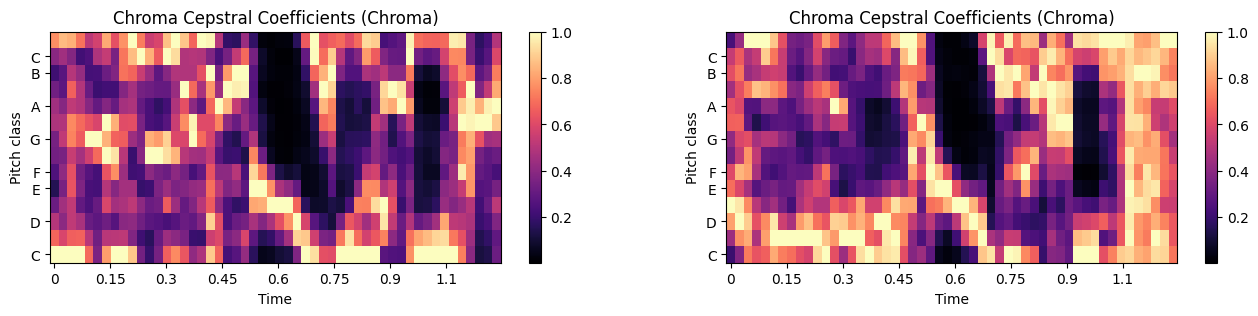

Dziękuję
(14, 52)
(14, 52)


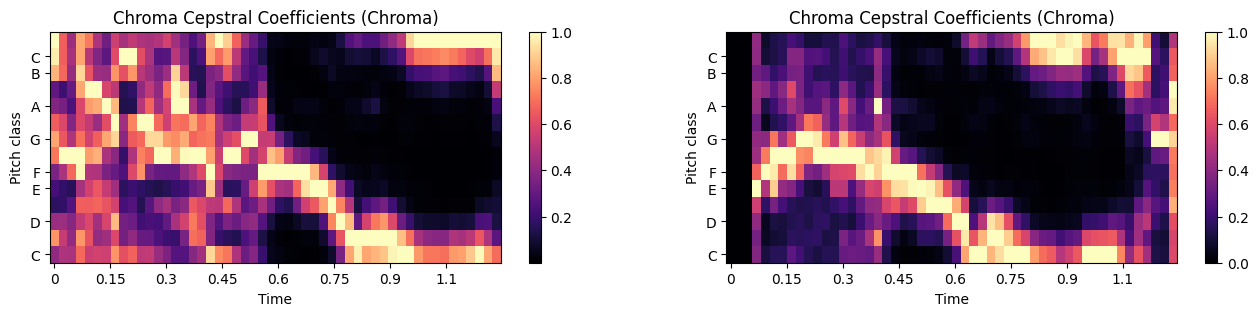

Kocham Was
(14, 52)
(14, 52)


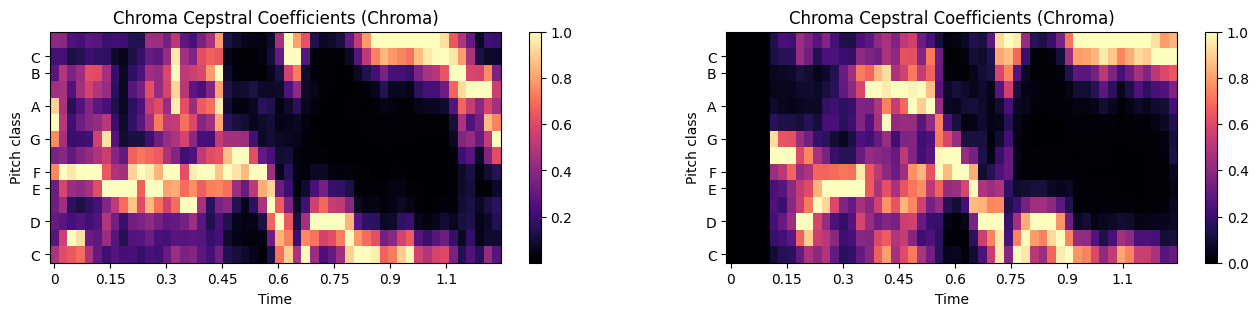

Mama
(14, 52)
(14, 52)


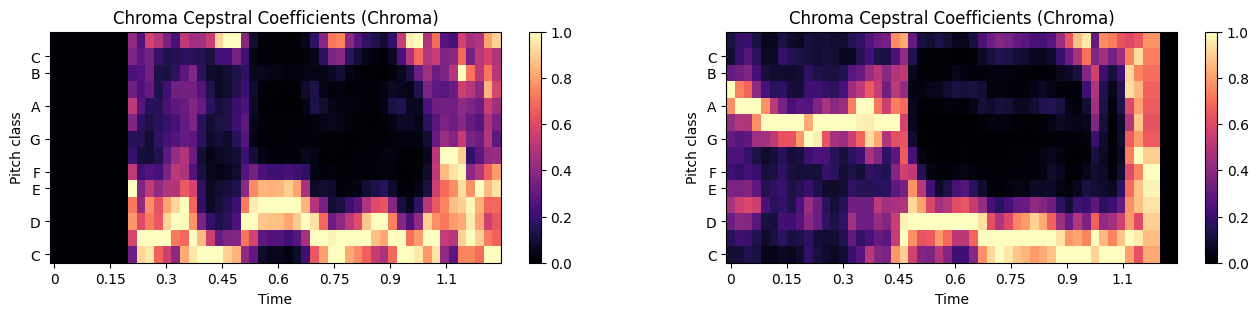

Tata
(14, 52)
(14, 52)


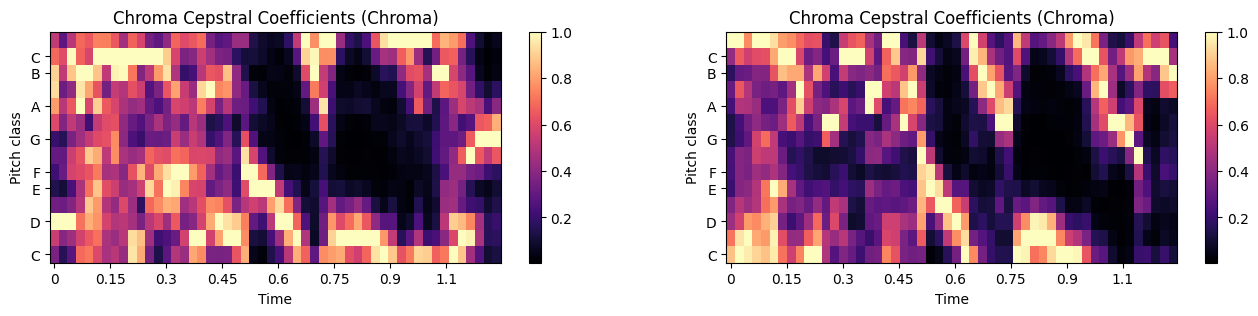

Wesołych Świąt
(14, 52)
(14, 52)


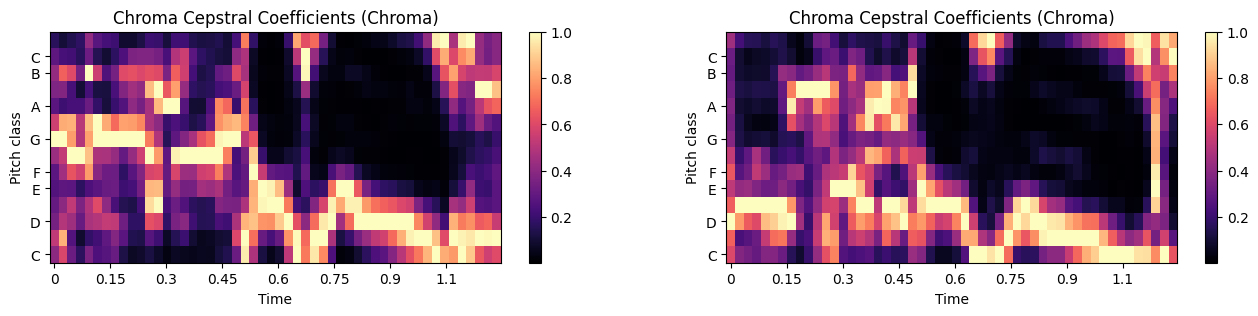

Łezka
(14, 52)
(14, 52)


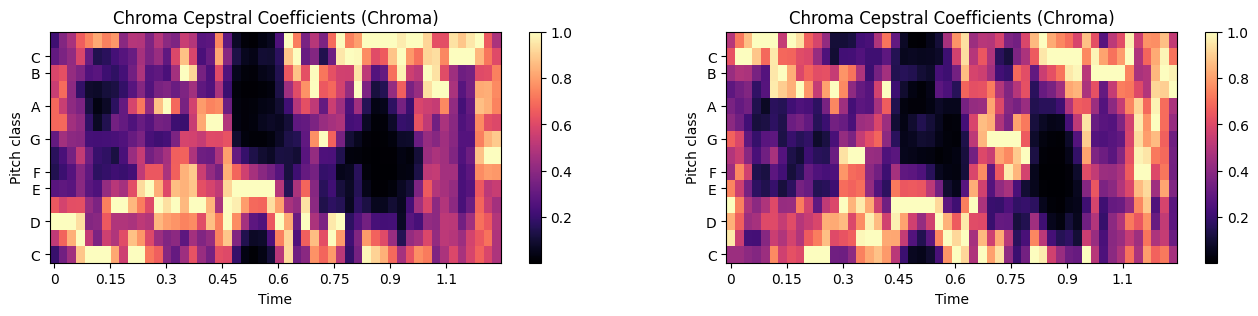

Ślina
(14, 52)
(14, 52)


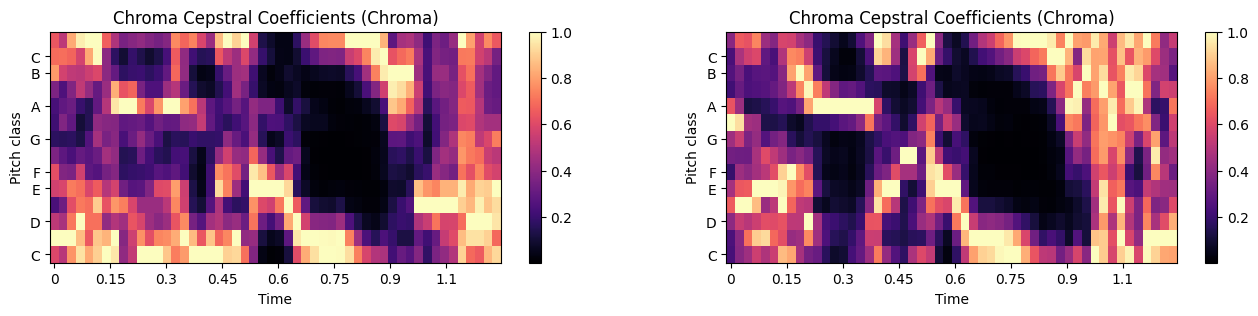

In [ ]:
def getChroma(audio_segment):
  audio_np_array = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)
  #audio_np_array = np.array(audio_bytes_list, dtype=np.float32)
  chroma = librosa.feature.chroma_stft(y=audio_np_array, sr=22050, n_chroma=14)
  print(chroma.shape)
  return chroma

def showChroma(audio_segment, audio_segment2):
  chroma = getChroma(audio_segment)
  chroma2 = getChroma(audio_segment2)

  plt.figure(figsize=(16, 3))

  # Plot the first chart on the left
  plt.subplot(1, 2, 1)
  plt.title('Chroma Cepstral Coefficients (Chroma)')
  librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
  plt.colorbar()

  # Plot the first chart on the left
  plt.subplot(1, 2, 2)
  plt.title('Chroma Cepstral Coefficients (Chroma)')
  librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time')
  plt.colorbar()

  plt.show()

def showChromaForAll(audio):
  words = getLabels(audio)
  for word in words:
    founded_records = [audio_record for audio_record in audio if hasattr(audio_record, 'label') and audio_record.label == word]
    if(len(founded_records)>2):
      print(word)
      showChroma(founded_records[len(founded_records) - 1].audio, founded_records[len(founded_records) - 2].audio)

showChromaForAll(audio)
#print('TEST:')
#showChromaForAll(test)

###Spectral Contrast

Cześć
(7, 52)
(7, 52)


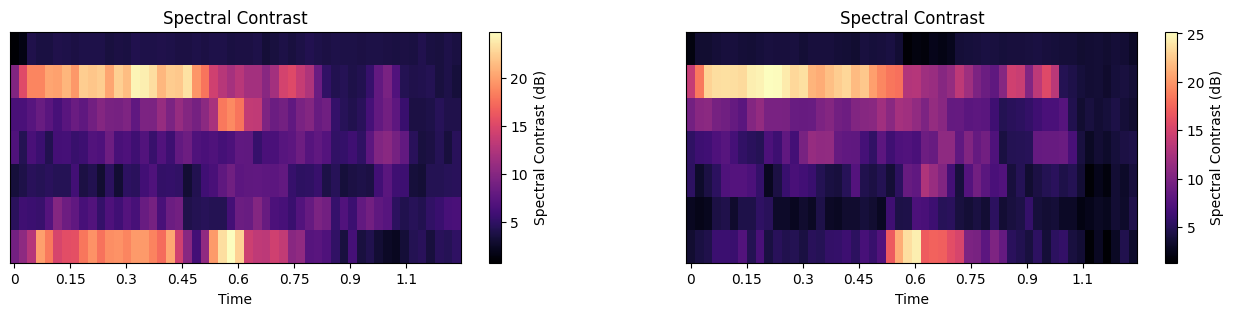

Dziękuję
(7, 52)
(7, 52)


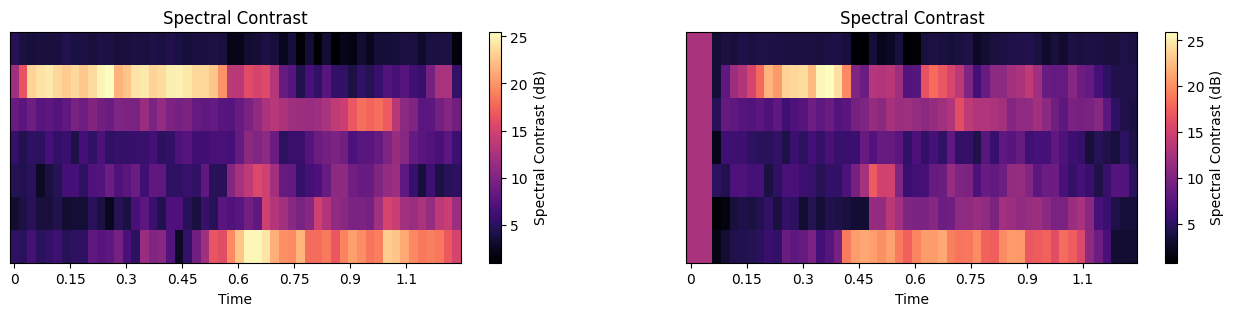

Kocham Was
(7, 52)
(7, 52)


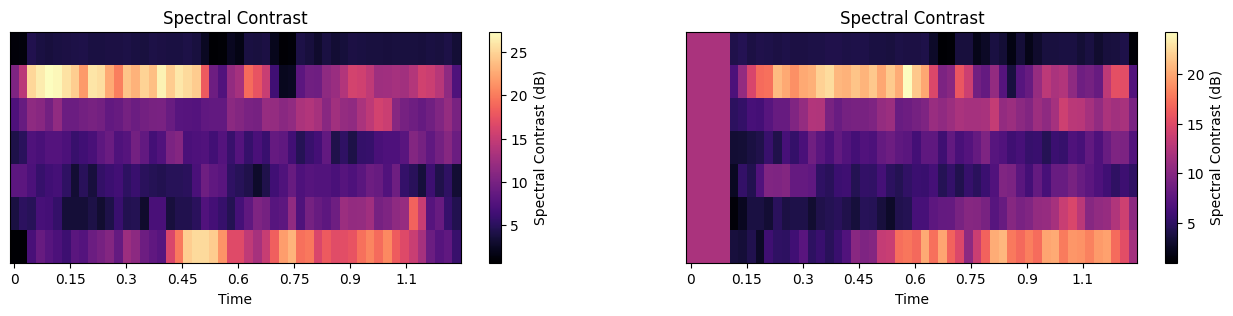

Mama
(7, 52)
(7, 52)


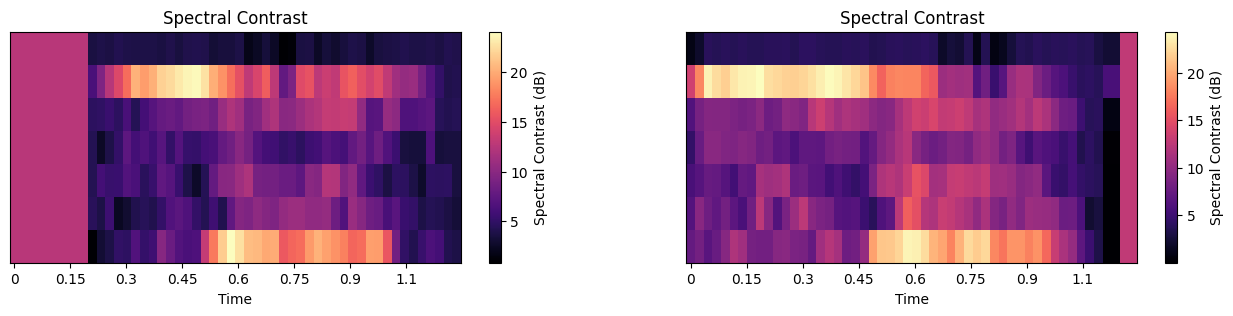

Tata
(7, 52)
(7, 52)


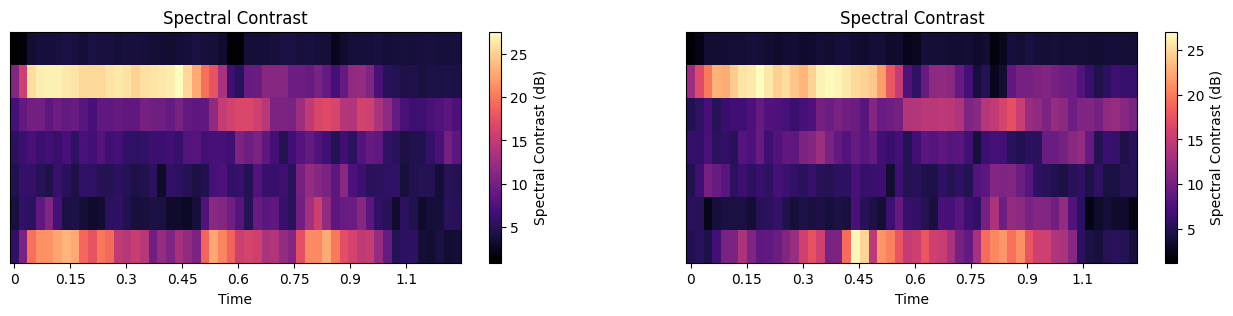

Wesołych Świąt
(7, 52)
(7, 52)


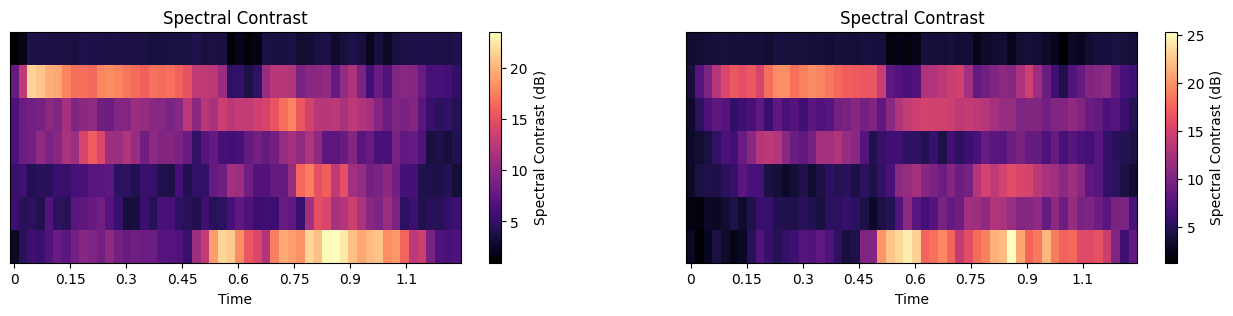

Łezka
(7, 52)
(7, 52)


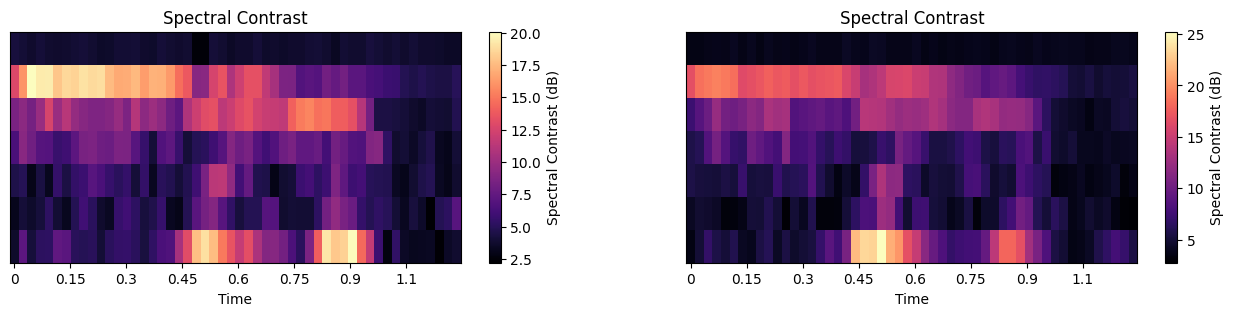

Ślina
(7, 52)
(7, 52)


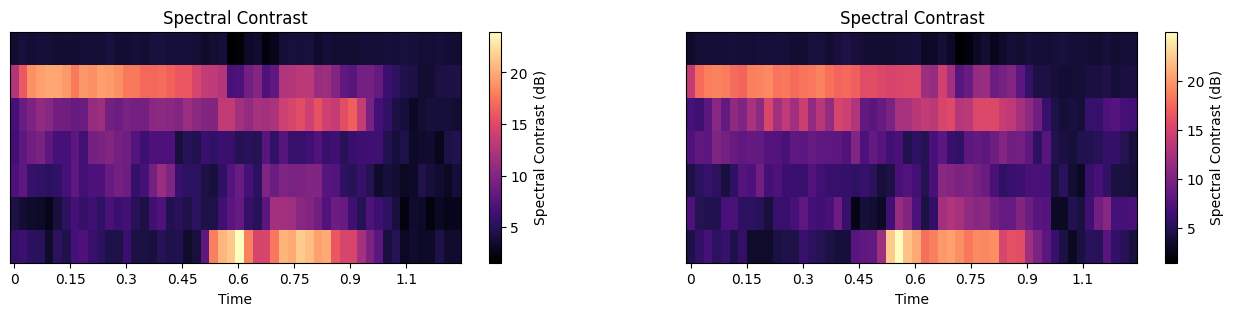

In [ ]:
def getSpectralContrast(audio_segment):
  #audio_segment = getAudioSegment(audio_bytes_list)
  audio_np_array = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)
  #audio_np_array = np.array(audio_bytes_list, dtype=np.float32)
  specialContrast = librosa.feature.spectral_contrast(y=audio_np_array, sr=22050, quantile=0.5)
  print(specialContrast.shape)
  return specialContrast

def showSpectralContrast(audio_bytes_list, audio_bytes_list2):
  spectral_contrast = getSpectralContrast(audio_bytes_list)
  spectral_contrast2 = getSpectralContrast(audio_bytes_list2)

  plt.figure(figsize=(16, 3))

  # Plot the first chart on the left
  plt.subplot(1, 2, 1)
  librosa.display.specshow(spectral_contrast, x_axis='time')
  plt.colorbar(label='Spectral Contrast (dB)')
  plt.title('Spectral Contrast')

  # Plot the second chart on the right
  plt.subplot(1, 2, 2)
  librosa.display.specshow(spectral_contrast2, x_axis='time')
  plt.colorbar(label='Spectral Contrast (dB)')
  plt.title('Spectral Contrast')

  plt.show()


def showSpectralContrastForAll(audio):
  words = getLabels(audio)
  for word in words:
    founded_records = [audio_record for audio_record in audio if hasattr(audio_record, 'label') and audio_record.label == word]
    if(len(founded_records)>0):
      print(word)
      showSpectralContrast(founded_records[len(founded_records) - 1].audio, founded_records[len(founded_records) - 2].audio)

showSpectralContrastForAll(audio)

###Spectogram

Cześć


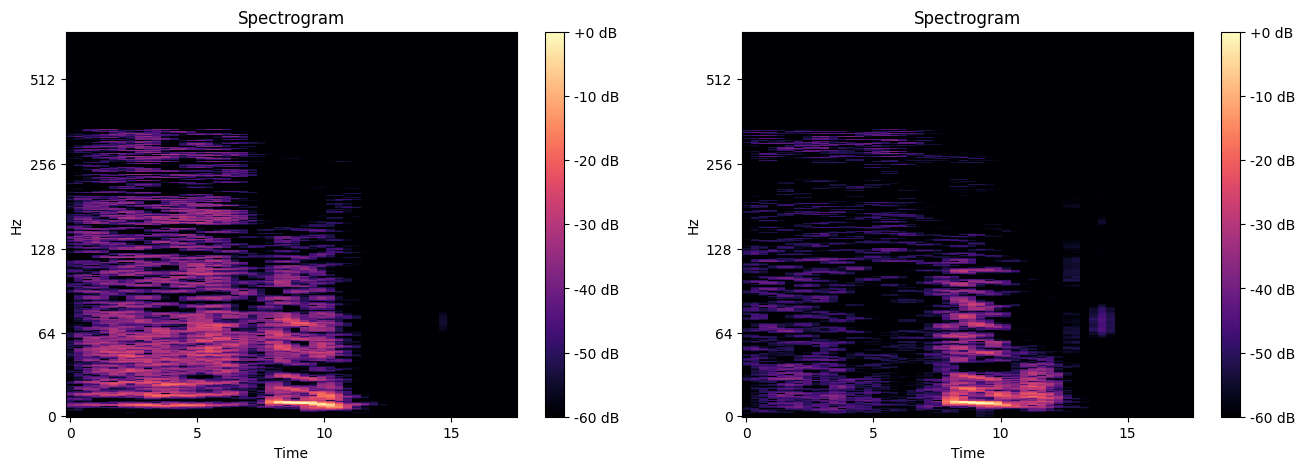

Dziękuję


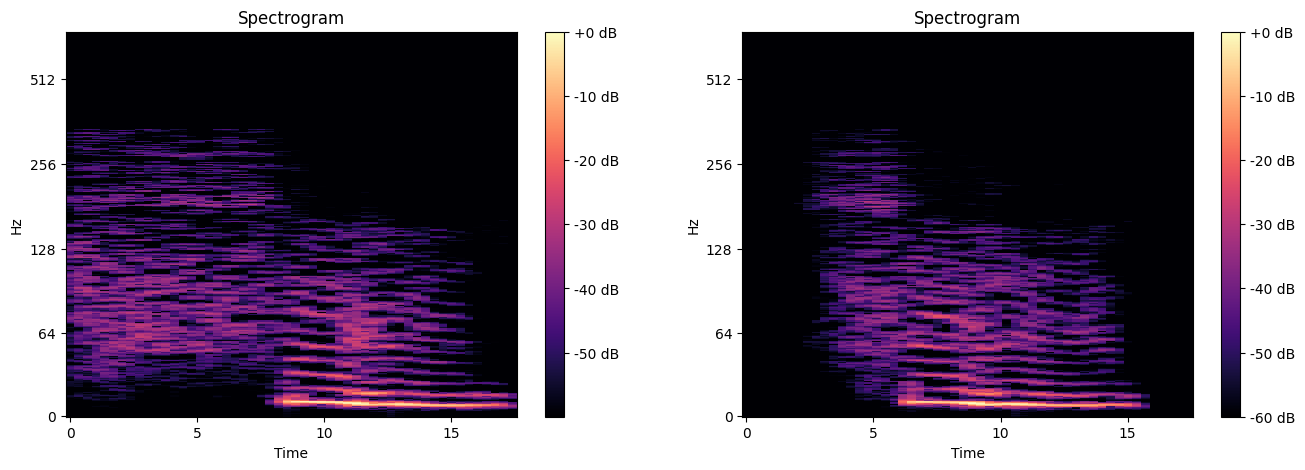

Kocham Was


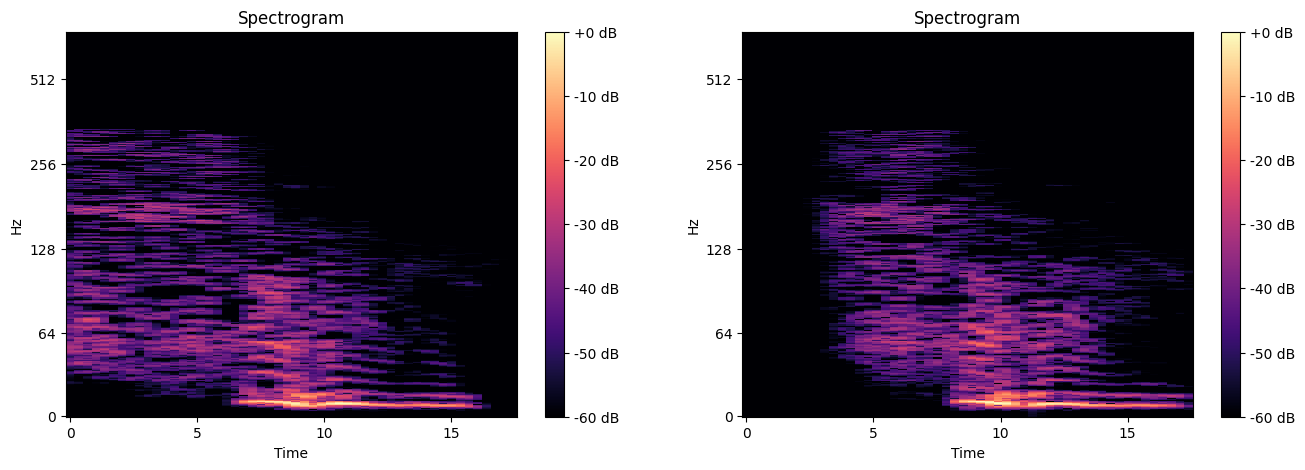

Mama


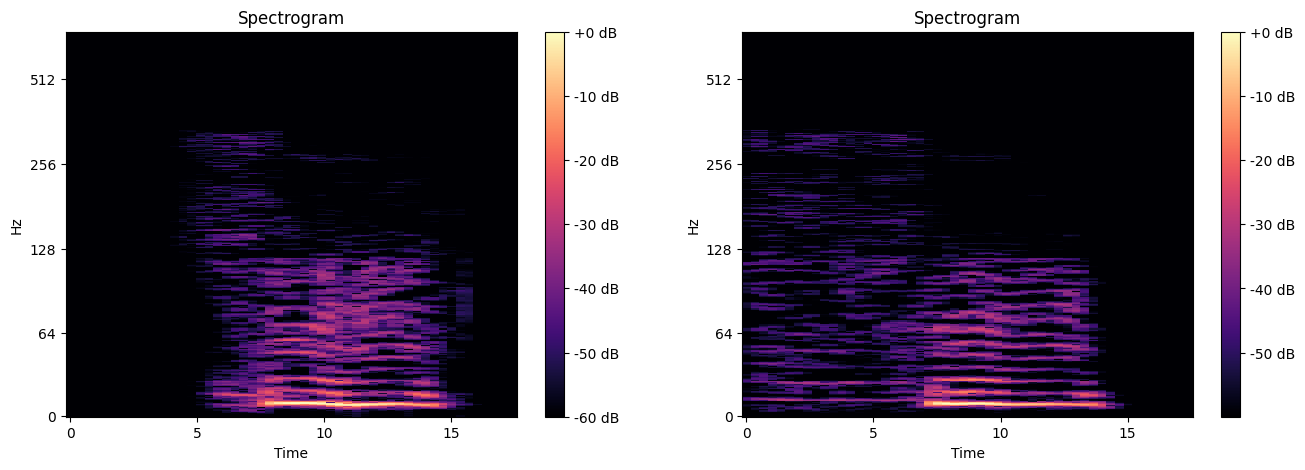

Tata


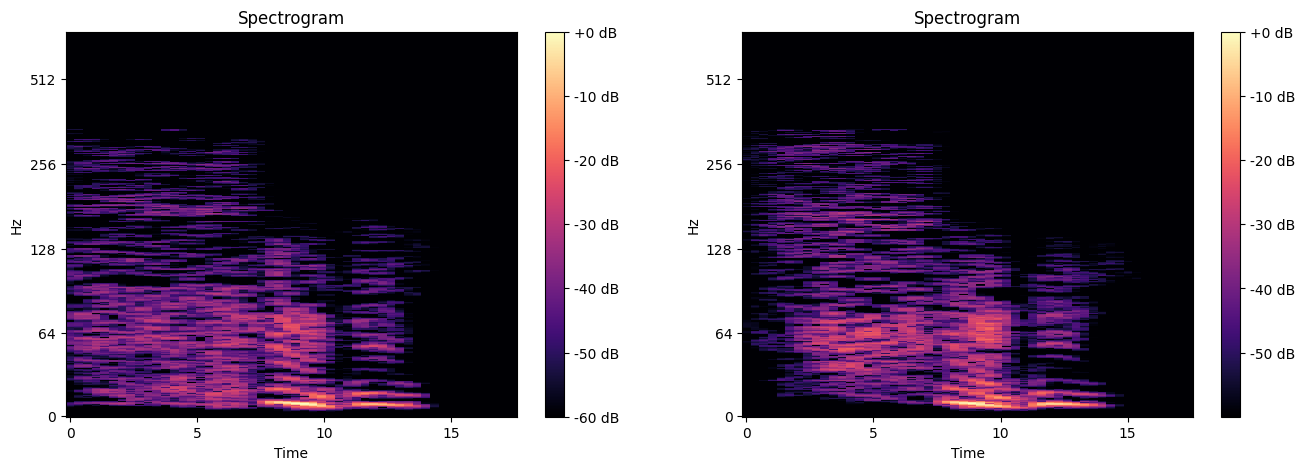

Wesołych Świąt


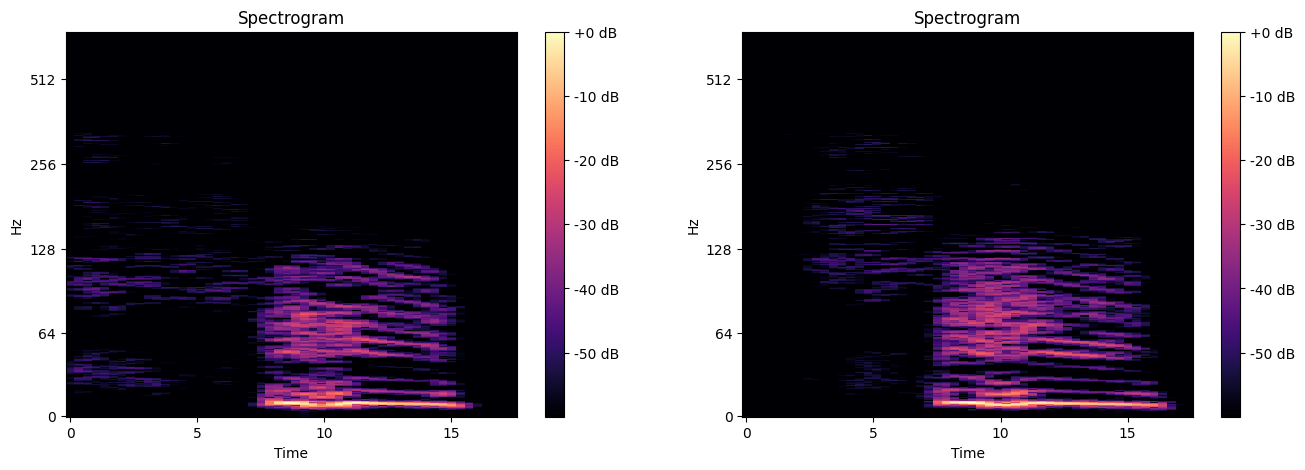

Łezka


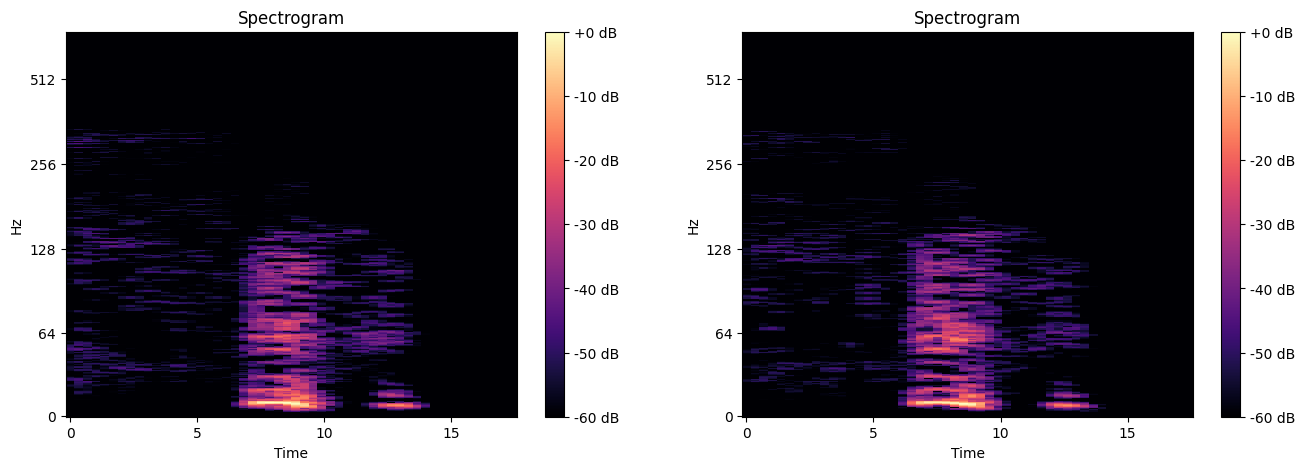

Ślina


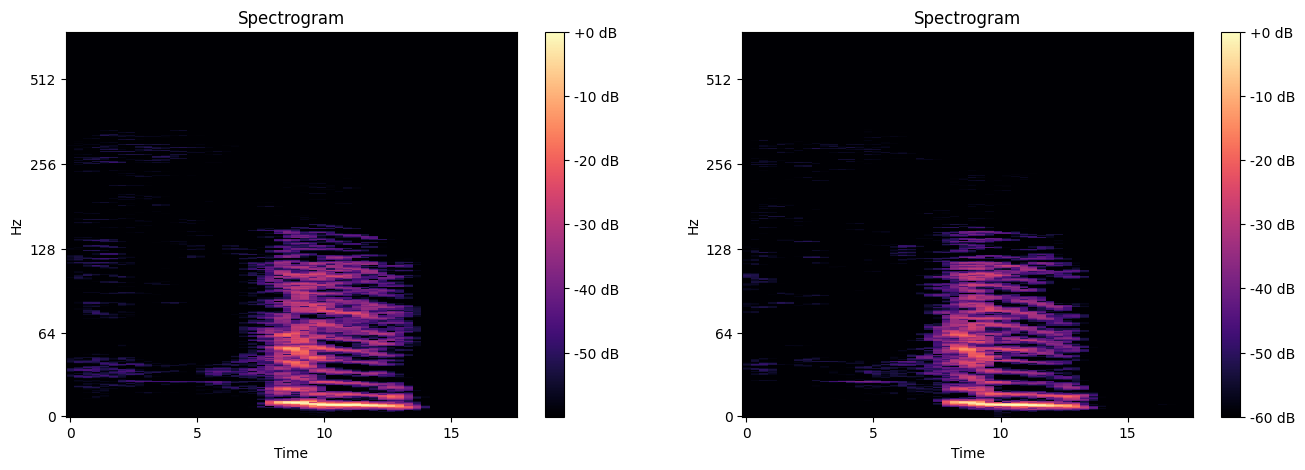

In [ ]:
def getSpectogram(audio_segment):
  #audio_segment = getAudioSegment(audio_bytes_list)
  audio_np_array = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)/ np.iinfo(np.int16).max
  #audio_np_array = np.array(audio_bytes_list, dtype=np.float32) / np.iinfo(np.int16).max
  D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_np_array)), ref=np.max, amin=1e-10, top_db=60)
  return D

def showSpectogram(audio_bytes_list, audio_bytes_list2):
  D = getSpectogram(audio_bytes_list)
  D2 = getSpectogram(audio_bytes_list2)

  plt.figure(figsize=(16, 5))

  # Plot the first chart on the left
  plt.subplot(1, 2, 1)
  librosa.display.specshow(D, sr=1500, x_axis='time', y_axis='log')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectrogram')

  # Plot the second chart on the right
  plt.subplot(1, 2, 2)
  librosa.display.specshow(D2, sr=1500, x_axis='time', y_axis='log')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectrogram')

  plt.show()

def showSpectogramForAll(audio):
  words = getLabels(audio)
  for word in words:
    founded_records = [audio_record for audio_record in audio if hasattr(audio_record, 'label') and audio_record.label == word]
    if(len(founded_records)>0):
      print(word)
      showSpectogram(founded_records[len(founded_records) - 1].audio, founded_records[len(founded_records) - 2].audio)

showSpectogramForAll(audio)

#ML model

##Perform train-test split

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

labels = getFullLabels(audio)
encoded_labels = label_encoding(labels)

# Encode the labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

one_hot_labels = to_categorical(encoded_labels, num_classes=len(set(encoded_labels)))
print(one_hot_labels.shape)

def extract_features(audio_data, labels, feature_types):
    mfccs = []
    ccc = []
    sc = []
    var = []
    ae=[]

    index = 0
    mshape = 0

    for word in audio_data:
        print(f"Extracting features progress: {int((index + 1)/len(audio_data)*100)} %, index: {index}")
        index = index + 1
        if 'mfcc' in feature_types:
            M = getMFCCs(word.audio)
            mfccs.append(M)
            print(M.shape)
        if 'ccc' in feature_types:
            C = getChroma(word.audio)
            ccc.append(C)
            #print(C.shape)
        if 'sc' in feature_types:
            SC = getSpectralContrast(word.audio)
            sc.append(SC)
            #print(SC.shape)
        if 'var' in feature_types:
            V = count_values_above_ranges(word.audio)
            var.append(V)
            #print(V)
        if 'ae' in feature_types:
            E=np.array(get_audio_envelope(word.audio))
            print(E.shape)
            E=E.reshape(1,52)


            ae.append(E)
            print(E.shape)



    if 'mfcc' in feature_types:
      mfcc_scaler = MinMaxScaler()
      mfccs_scaled = [mfcc_scaler.fit_transform(M) for M in mfccs]
      mfccs_array = np.array(mfccs_scaled)
      print(mfccs_array.shape)
    if 'ccc' in feature_types:
      ccc_scaler = MinMaxScaler()
      ccc_scaled = [ccc_scaler.fit_transform(C) for C in ccc]
      ccc_array = np.array(ccc_scaled)
      print(ccc_array.shape)
    if 'sc' in feature_types:
      sc_scaler = MinMaxScaler()
      sc_scaled = [sc_scaler.fit_transform(SC) for SC in sc]
      sc_array = np.array(sc_scaled)
      print(sc_array.shape)
    if 'var' in feature_types:
      var_scaler=MinMaxScaler()
      var_scaled = [var_scaler.fit_transform(V) for V in var]
      var_array = np.array(var_scaled)

      new_shape = (ccc_array.shape[0], 5, 52)
      adjusted_features = np.zeros(new_shape)
      adjusted_features[:, :, :3] = var_array
      var_array = adjusted_features
      print(var_array.shape)

    if 'ae' in feature_types:
      ae_scaler = MinMaxScaler()
      ae_scaled = [ae_scaler.fit_transform(E) for E in ae]
      ae_array = np.array(ae_scaled)
      print(ae_array.shape)


    # Concatenate the scaled arrays along the second axis (axis=1)
    features = np.concatenate((mfccs_array,ccc_array,sc_array, var_array,ae_array), axis=1)
    #features=[mfccs_array,ccc_array,sc_array, var_array,ae_array]

    #features = mfccs_array

    # Assuming mfccs is your list of MFCC features and labels is your list of corresponding labels

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(features, one_hot_labels, test_size=0.20)


    return features, one_hot_labels, label_encoder, X_train, X_test, y_train, y_test

# Example usage
selected_feature_types = ['mfcc','ccc', 'sc','var','ae']
features, labels, label_encoder, X_train, X_test, y_train, y_test = extract_features(audio, labels, selected_feature_types)
#features, labels, label_encoder, X_train, X_test, y_train, y_test = extract_features([audio[0]], [labels[0]], selected_feature_types)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(405, 8)
Extracting features progress: 0 %, index: 0
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 0 %, index: 1
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 0 %, index: 2
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 0 %, index: 3
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 1 %, index: 4
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 1 %, index: 5
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 1 %, index: 6
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 1 %, index: 7
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 2 %, index: 8
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 2 %, index: 9
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52,)
(1, 52)
Extracting features progress: 2 %, index: 10
(20, 52)
(14, 52)
(7, 52)
(5, 3)
(52

##Create model

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras import layers, models
import tensorflow as tf

def create_custom_model(lr=1e-4):
    # Create an optimizer with the custom learning rate
    optimizer = Adam(lr=lr)

    # Define the neural network model
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(features.shape[1], features.shape[2], 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation='relu'))
    # OUTPUTLAYER should be uniqe samples like len(set(labels)) as it represents number of unique words in data so having 5 words it would be 5

    model.add(layers.Dense(7, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Create the model
lr1=1e-4
custom_model = create_custom_model(lr1)

# Print the summary of the model architecture
custom_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 45, 50, 128)       1280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 25, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 22, 25, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 23, 128)       147584    
                                                                 
 batch_normalization_1 (Bat  (None, 20, 23, 128)       512       
 chNormalization)                                                
                                                                 
 flatten_16 (Flatten)        (None, 58880)            

In [ ]:
#MODEL MULTIHEAD

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def build_multi_head_cnn(input_shapes, num_classes):

    inputs = []
    heads = []

    for shape in input_shapes:
        input_layer = Input(shape=shape)
        inputs.append(input_layer)

        head = Conv2D(16, (3, 3), activation='relu',padding='same')(input_layer)
        head = Flatten()(head)
        heads.append(head)


    concatenated = Concatenate()(heads if len(heads) > 1 else heads[0])

    x = Dense(64, activation='relu')(concatenated)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define your input shapes based on the feature arrays
input_shapes = [(20, 52, 1), (14, 52, 1), (7, 52, 1), (5, 52, 1), (1, 52, 1)]
num_classes = 8

modelmh = build_multi_head_cnn(input_shapes, num_classes)
modelmh.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20, 52, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 14, 52, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 7, 52, 1)]           0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 5, 52, 1)]           0         []                            
                                                                                              

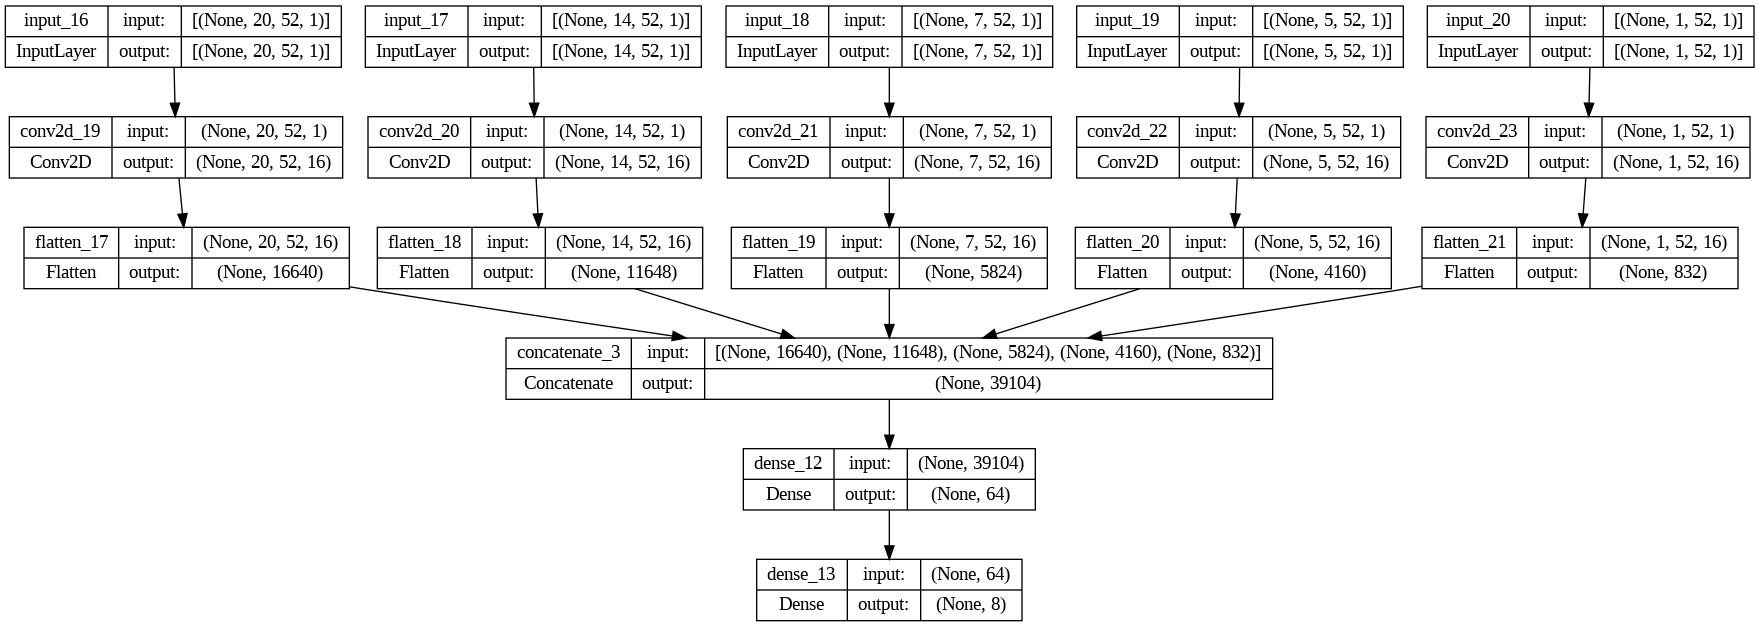

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Assuming 'modelmh' is already defined and built
# Generate the plot
plot_model(modelmh, to_file='/content/modelmh_plot.png', show_shapes=True, show_layer_names=True)

# Display the generated plot
display(Image(filename='/content/modelmh_plot.png'))


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split dimensions (cumulative)
split_dims = [20, 34, 41, 46]  # Cumulative sums of feature dimensions: 20, 14, 7, 5, 1


mfccs_array, ccc_array, sc_array, var_array, ae_array = np.split(features, split_dims, axis=1)

rst=71
mfccs_train, mfccs_test, labels_train, labels_test = train_test_split(mfccs_array, labels, test_size=0.2,random_state=rst)
ccc_train, ccc_test, _, _ = train_test_split(ccc_array, labels, test_size=0.2, random_state=rst)
sc_train, sc_test, _, _ = train_test_split(sc_array, labels, test_size=0.2, random_state=rst)
var_train, var_test, _, _ = train_test_split(var_array, labels, test_size=0.2, random_state=rst)
ae_train, ae_test, _, _ = train_test_split(ae_array, labels, test_size=0.2, random_state=rst)




history = modelmh.fit(
    [mfccs_train, ccc_train, sc_train, var_train, ae_train], labels_train,
    epochs=25,
    batch_size=10,
    validation_data=([mfccs_test, ccc_test, sc_test, var_test, ae_test], labels_test),
    # Add callbacks as necessary
)


Epoch 1/25
33/33 [==============================] - 11s 82ms/step - loss: 2.0030 - accuracy: 0.2840 - val_loss: 1.5938 - val_accuracy: 0.4074
Epoch 2/25
33/33 [==============================] - 0s 14ms/step - loss: 1.1802 - accuracy: 0.6512 - val_loss: 1.0697 - val_accuracy: 0.6543
Epoch 3/25
33/33 [==============================] - 0s 14ms/step - loss: 0.6565 - accuracy: 0.8426 - val_loss: 0.6445 - val_accuracy: 0.8519
Epoch 4/25
33/33 [==============================] - 0s 14ms/step - loss: 0.3156 - accuracy: 0.9414 - val_loss: 0.4392 - val_accuracy: 0.8889
Epoch 5/25
33/33 [==============================] - 1s 19ms/step - loss: 0.1617 - accuracy: 0.9753 - val_loss: 0.4057 - val_accuracy: 0.8889
Epoch 6/25
33/33 [==============================] - 0s 13ms/step - loss: 0.0956 - accuracy: 0.9877 - val_loss: 0.3422 - val_accuracy: 0.9259
Epoch 7/25
33/33 [==============================] - 1s 16ms/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.4554 - val_accuracy: 0.8395
Epoch 8/25
3

In [ ]:
last_layer_output = modelmh.layers[-1].output
output_model = tf.keras.Model(inputs=modelmh.input, outputs=last_layer_output)
output_values = output_model.predict([mfccs_test, ccc_test, sc_test, var_test, ae_test])
#print(output_values)

y_pred=modelmh.predict([mfccs_test, ccc_test, sc_test, var_test, ae_test])
#print(X_test)
#print(y_pred)
pred_array=[]

for x in y_pred:
  threshold = 0.05
  if (np.argmax(x) < threshold):
    predicted_classes=9
  else :
    predicted_classes = np.argmax(x)
  pred_array.append(predicted_classes)

3/3 [==============================] - 0s 4ms/step


##Train model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a custom learning rate
lr1 = 1e-3
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=50,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=15, verbose=1, mode="max", min_lr=1e-7
)
#print(X_test[0])
#input_shape=features[0].shape
#X_train, X_test, y_train, y_test = train_test_split(features, one_hot_labels, test_size=0.15)

#print(y_test)
# RESHAPE FOR CNN 2D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# Create an optimizer with the custom learning rate
optimizer1 = Adam(lr=lr1)
# Define the neural network model

# Create the model
model = create_custom_model(lr1)

# Print the summary of the model architecture
model.summary()

print(y_train.shape[0])
print(y_train.shape[1])
print(y_test.shape[0])
print(y_test.shape[1])

history=model.fit(X_train, y_train, epochs=100, batch_size=10,callbacks=[EarlyStop, ReduceLR], validation_data=(X_test, y_test))

last_layer_output = model.layers[-1].output
output_model = tf.keras.Model(inputs=model.input, outputs=last_layer_output)
output_values = output_model.predict(X_test)
#print(output_values)

y_pred=model.predict(X_test)
#print(X_test)
#print(y_pred)
pred_array=[]

for x in y_pred:
  threshold = 0.2
  if (np.argmax(x) < threshold):
    predicted_classes=9
  else :
    predicted_classes = np.argmax(x)
  pred_array.append(predicted_classes)




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 10, 50, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 25, 128)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 5, 25, 128)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 23, 128)        147584    
                                                                 
 batch_normalization_3 (Bat  (None, 3, 23, 128)        512       
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 8832)             

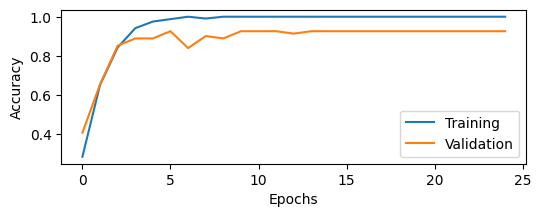

0.16049382716049382
[7, 7, 2, 4, 5, 4, 4, 9, 3, 1, 9, 7, 6, 6, 1, 2, 5, 3, 9, 3, 9, 2, 4, 1, 2, 3, 5, 6, 7, 6, 5, 6, 7, 3, 5, 2, 9, 9, 4, 5, 2, 1, 9, 7, 9, 2, 4, 6, 1, 4, 4, 4, 2, 9, 1, 4, 6, 6, 9, 4, 3, 2, 1, 9, 9, 1, 9, 2, 7, 3, 6, 4, 5, 3, 3, 6, 5, 6, 2, 7, 9]
[3 2 1 1 5 1 1 1 7 1 6 0 4 4 1 3 2 2 0 4 7 7 5 1 2 0 4 5 3 5 6 4 4 0 2 1 4
 5 1 2 1 4 2 2 6 7 0 3 1 2 4 6 3 2 5 7 6 3 0 4 2 3 7 7 4 1 4 2 3 5 6 6 1 5
 0 5 2 6 0 5 7]


In [ ]:
true_classes = np.argmax(y_test, axis=1)
accuracy = np.mean(np.equal(pred_array, true_classes))

# Plot training and validation accuracy
plt.figure(figsize=(6, 2))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()


accuracy = np.mean(np.equal(pred_array, true_classes))
print(accuracy)
print(pred_array)
print(true_classes)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from google.colab import files

model.save('arthur_model_ccc_p_allejujah.h5')
files.download('arthur_model_ccc_p_allejujah.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Test model

In [ ]:
#print(features[0])
test = features[110]
reshaped_test = test.reshape((1, test.shape[0], test.shape[1], 1))
#test_features = features[0]
result = model.predict(reshaped_test)
print(result)
print(test.shape)

NameError: name 'model' is not defined

In [ ]:
accuracy = np.mean(np.equal(pred_array, true_classes))
print(accuracy)
print(pred_array)
print(true_classes)

0.16049382716049382
[7, 7, 2, 4, 5, 4, 4, 9, 3, 1, 9, 7, 6, 6, 1, 2, 5, 3, 9, 3, 9, 2, 4, 1, 2, 3, 5, 6, 7, 6, 5, 6, 7, 3, 5, 2, 9, 9, 4, 5, 2, 1, 9, 7, 9, 2, 4, 6, 1, 4, 4, 4, 2, 9, 1, 4, 6, 6, 9, 4, 3, 2, 1, 9, 9, 1, 9, 2, 7, 3, 6, 4, 5, 3, 3, 6, 5, 6, 2, 7, 9]
[3 2 1 1 5 1 1 1 7 1 6 0 4 4 1 3 2 2 0 4 7 7 5 1 2 0 4 5 3 5 6 4 4 0 2 1 4
 5 1 2 1 4 2 2 6 7 0 3 1 2 4 6 3 2 5 7 6 3 0 4 2 3 7 7 4 1 4 2 3 5 6 6 1 5
 0 5 2 6 0 5 7]


###Check for new test data

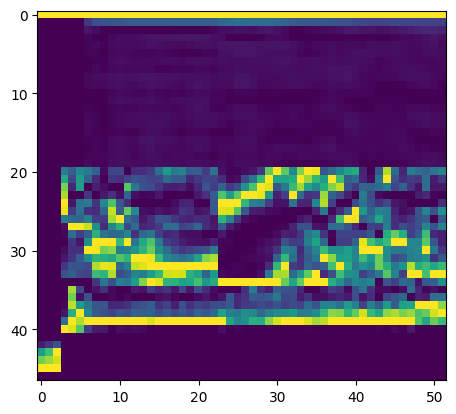

In [ ]:
plt.imshow(features[12])

(12, 52)
1/1 [==============================] - 0s 41ms/step
[[0.00826433 0.90213645 0.02228546 0.04993599 0.0173777 ]]
Dziękuję


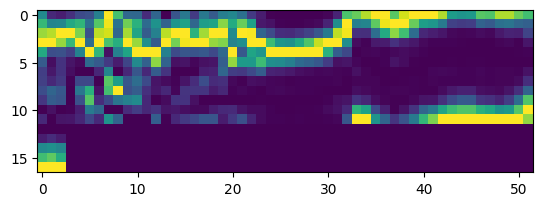

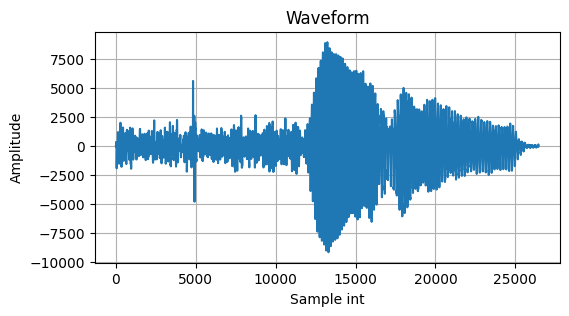

In [ ]:
def get_highest_value_label(nparray, labels):
    max_index = np.argmax(nparray)

    if max_index < len(labels):
        return labels[max_index]
    else:
        return None

def get_new_test_data(user):
    audio_ref = user.collection("audio_test")
    audio_data = audio_ref.stream()
    audio_bytes_lists = []

    for index, audio_record in enumerate(audio_data):
      label = audio_record.to_dict()['label']
      date = audio_record.to_dict()['date']
      audio_bytes_list = audio_record.to_dict()['audioData']
      audio_bytes_lists.append(audio_bytes_list)
    return audio_bytes_lists

def prepare_data_to_test(audio_bytes_list):
    custom_feature = count_values_above_ranges(audio_bytes_list)
    ccc = getChroma(audio_bytes_list)

    ccc_scaler = MinMaxScaler()
    ccc_scaled = [ccc_scaler.fit_transform(ccc)]
    ccc_array = np.array(ccc_scaled)

    custom_feature_scaler = MinMaxScaler()
    custom_feature_scaled = [custom_feature_scaler.fit_transform(custom_feature)]
    custom_feature_array = np.array(custom_feature_scaled)

    new_shape = (1, 5, 52)
    adjusted_custom_feature = np.zeros(new_shape)
    adjusted_custom_feature[:, :, :3] = custom_feature_array
    custom_feature_array = adjusted_custom_feature

    test_features = np.concatenate((ccc_array, custom_feature_array), axis=1)
    feature = test_features[0]

    return feature

##labels: Czesc, error, czesc, tata, tata, mama, mama, error, kocham was, kocham was, dziekuje, dziekuje
labels = ['Cześć', 'Dziękuję', 'Kocham Was', 'Mama', 'Tata']
test_data = get_new_test_data(piotr)

test_audio = test_data[11]
feature = prepare_data_to_test(test_audio)
plt.imshow(feature)
data_to_test = feature.reshape((1, feature.shape[0], feature.shape[1], 1))
result = model.predict(data_to_test)
print(result)
label = get_highest_value_label(result, labels)
print(label)

audio_segment = getAudioSegment(test_audio)
showWaveform(audio_segment)



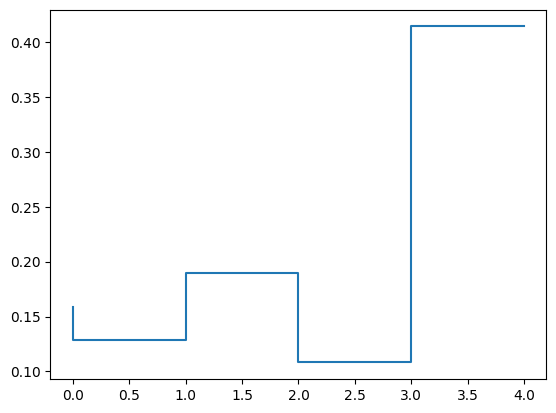

In [ ]:
plt.step(range(5) , output_values[50])

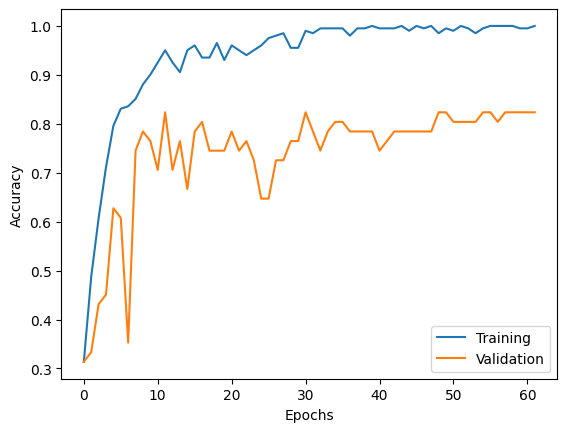

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

# Assuming features and one_hot_labels are defined
loo = LeaveOneOut()

# Initialize variables to store evaluation metrics and training histories
total_accuracy = 0
total_loss = 0
training_histories = []


EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=60,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.5, patience=10, verbose=1, mode="max", min_lr=1e-7
)


# Perform Leave One Out Cross-Validation
for index, (train_index, test_index) in enumerate(loo.split(features)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = one_hot_labels[train_index], one_hot_labels[test_index]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
    optimizer1 = Adam(learning_rate=lr1)
    lr1 = 1e-4
    # Define and compile the model
    optimizer1 = Adam(lr=lr1)
    # Define the neural network model

    # Create the model
    model = create_MLP(lr1)

    # Print the summary of the model architecture
    #model.summary()
    #print(y_test)
    # Train the model

    history=model.fit(X_train, y_train, epochs=200, batch_size=10,callbacks=[EarlyStop, ReduceLR],verbose=0)
    #history = model.fit(X_train, y_train, epochs=150, batch_size=6, verbose=1)
    training_histories.append(history.history)

    # Evaluate the model on the test sample
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    total_loss += loss
    total_accuracy += accuracy

    subject_index = test_index[0]  # Get the subject index from the test index array
    subject_label = labels[subject_index]  # Get the corresponding label from the labels list
    encoded_label = encoded_labels[subject_index]  # Get the corresponding encoded label
    predicted_encoded_label = np.argmax(model.predict(X_test), axis=-1)[0]  # Predict the label and get the encoded value
    predicted_label = label_encoder.inverse_transform([predicted_encoded_label])[0]  # Inverse transform to get the label

    print(f"Subject Index: {subject_index}, Label: {subject_label}, "f"Predicted Label: {predicted_label} ({accuracy:.4f} Accuracy)")

# Calculate and print average loss and accuracy across all iterations
average_loss = total_loss / len(features)
average_accuracy = total_accuracy / len(features)
print("Average Loss: {:.4f}".format(average_loss))
print("Average Accuracy: {:.4f}".format(average_accuracy))

# Plot training histories on the same plot
plt.figure(figsize=(12, 6))
for history in training_histories:
    plt.plot(history['accuracy'])  # Use 'accuracy' or 'loss' based on your preference
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training History for Leave One Out Cross-Validation')
plt.show()




Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 67: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 77: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 87: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 97: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Restoring model weights from the end of the best epoch: 47.

Epoch 107: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 107: early stopping


1/1 [==============================] - 0s 91ms/step


Subject Index: 0, Label: [1. 0. 0. 0. 0.], Predicted Label: Tata (0.0000 Accuracy)

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 84: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 94: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 104: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 114: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 124: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 151: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 161: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 177: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 187: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 197: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.


1/1 [==============================] - 0s 86ms/step


Subject Index: 1, Label: [1. 0. 0. 0. 0.], Predicted Label: Tata (0.0000 Accuracy)

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 68: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 78: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 89: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 109: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 119: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 129: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 139: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 168: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 179: ReduceLROnPlateau reducing learning rate 

KeyboardInterrupt: ignored